# Member: Sharvil Vilas Turbadkar/ Yueyuan He/ Jian Jian

# Environment Setup

Importing all Libraries
-----------------

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing,neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,r2_score,roc_curve,roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import tree,linear_model
from sklearn import svm
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn import model_selection
from matplotlib.legend_handler import HandlerLine2D
import plotly.graph_objects as go
from collections import Counter
import operator

----------

Reading the CSV File
------------

In [149]:
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv("/content/drive/Shared drives/IST-707-project/rotten_tomatoes_movies.csv")
#data = pd.read_csv("./rotten_tomatoes_movies.csv")
seed=77

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [150]:
df=data.copy()

------------

# Business Question

- Which attributes will affect the likelihood of watching a movie the most?
- Which class of movies has the strongest polarity?
- Do critic and audience views match?
- Which writers, directors and studio have the strongest polarity? Quantifying polarity across time to gauge market effects.
- Do directors and actors digress from their genre to star in the different labels of movies to change polarity?

# EDA& Data Wrangling

 ## Missing values using median, mean or mode given the distribution of data

- KNN: If there are many missing values we can cluster the data and then replace the missing value after grouping by the mean

In [151]:
# Codeblock
data.head(2)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19


In [152]:
data.shape

(16638, 23)

In [153]:
data.describe()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
count,16483.000000,16638.000000,16638.000000,16386.000000,1.638600e+04,16638.000000,16638.000000,16638.000000
mean,102.391494,60.466522,56.607104,60.470829,1.524797e+05,14.594242,35.730496,20.867592
std,25.028011,28.587230,66.383800,20.462368,1.817736e+06,14.774244,50.795198,29.995032
min,1.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,8.642500e+02,3.000000,6.000000,3.000000
50%,99.000000,66.000000,28.000000,62.000000,4.876500e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,76.000000,77.000000,2.875200e+04,24.000000,43.000000,24.000000
max,2000.000000,100.000000,497.000000,100.000000,3.579764e+07,64.000000,470.000000,296.000000


Replacing Audience Rating by median

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin


class ColumnwiseMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._median_imputed_cols = cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        numeric_data = x[self._median_imputed_cols]
        numeric_data = numeric_data.fillna(numeric_data.median())

        for col in numeric_data.columns:
            x[col] = numeric_data[col]
        return x

pipe = Pipeline([
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count','runtime_in_minutes','audience_rating'])),
])

result = pipe.transform(df)
result.isnull().sum()


rotten_tomatoes_link                0
movie_title                         0
movie_info                         24
critics_consensus                8329
poster_image_url                    0
rating                              0
genre                              17
directors                         114
writers                          1349
cast                              284
in_theaters_date                  815
on_streaming_date                   2
runtime_in_minutes                  0
studio_name                       416
tomatometer_status                  0
tomatometer_rating                  0
tomatometer_count                   0
audience_status                   252
audience_rating                     0
audience_count                      0
audience_top_critics_count          0
audience_fresh_critics_count        0
audience_rotten_critics_count       0
dtype: int64

Dropping Critic Concensus as it is a redundant column


Plots
-------


Heatmap of correlation matrix which gives us an intuitive sense of correlation between variables 

<Figure size 432x288 with 0 Axes>

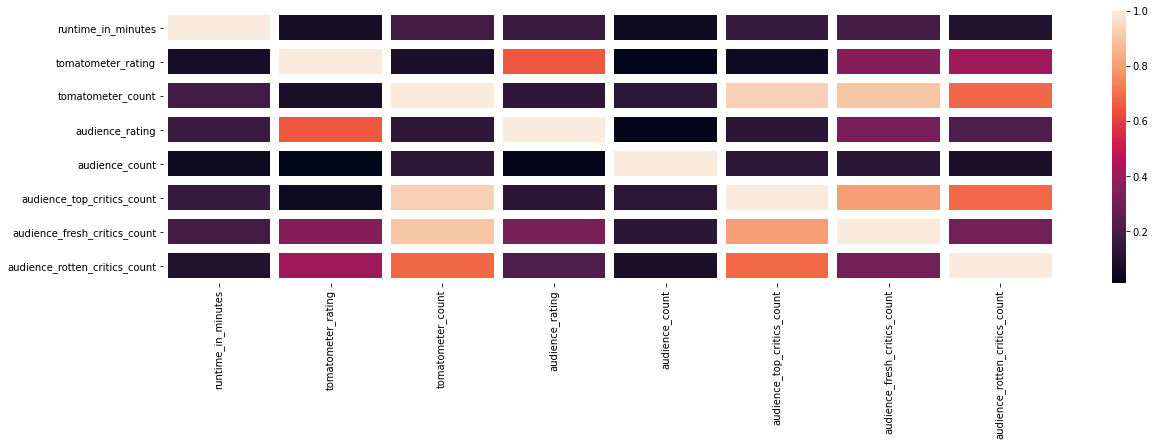

In [155]:
import seaborn as sns
plt.clf()
fig=plt.figure(figsize=(20,5))
sns.heatmap(result.corr().abs(),linecolor='white',linewidths=8)

Directors with the highest audience ratings 

In [156]:
result['directors'].count()
result[['directors','audience_rating']] \
  .groupby('directors',as_index=False) \
  .mean() \
  .sort_values(by='audience_rating',ascending=False) \
  .head(5)

,directors,audience_rating
8049,Vlada Knowlton,100.0
5000,Macky Alston,100.0
4761,Laurent Gentot,100.0
6548,Rhys Thomas,100.0
3052,Heather MacDonald,100.0


It does not however have an intutive sense as an established director does not make a single movie .It can be an outlier which can be a serious problem

FIltering by directors that have made more than 8 movies 

In [157]:
filtered=result.groupby('directors').filter(lambda x: len(x)>=8)
filtered.shape

(3528, 23)

Most Reverred Directors according to audience  across the Globe

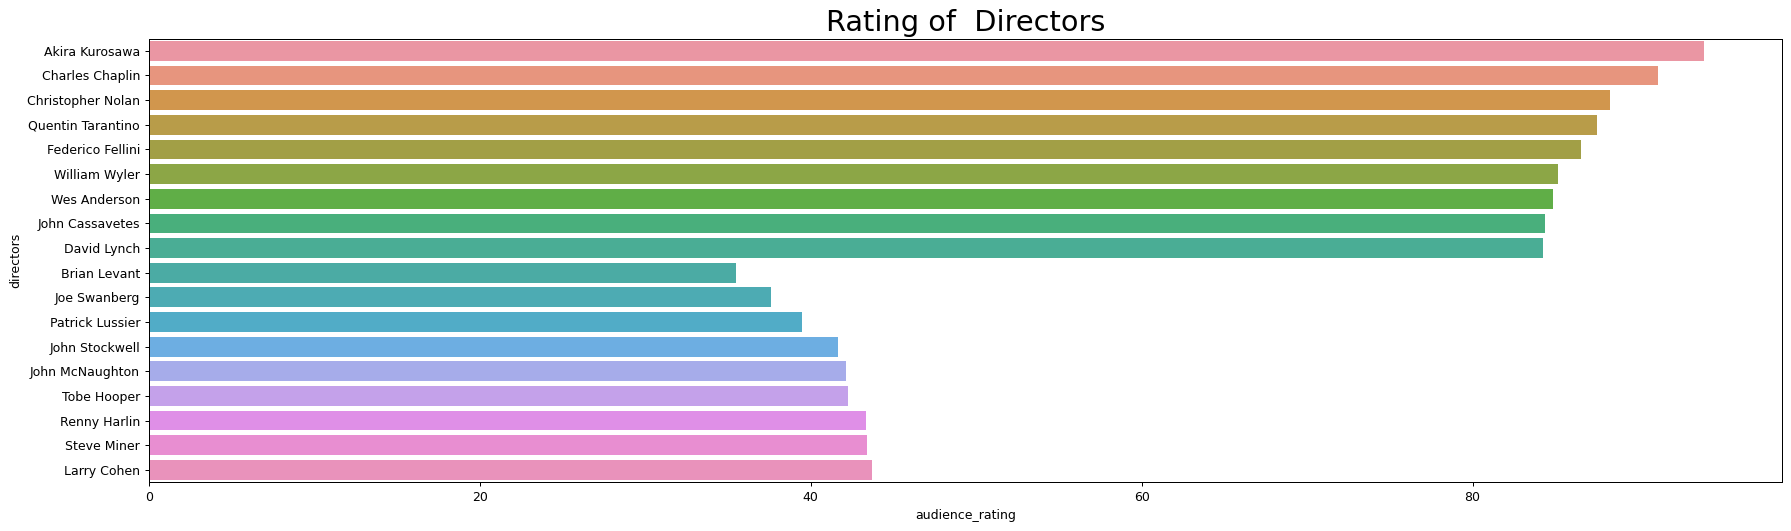

In [158]:
fig, ax =plt.subplots(figsize=(20,6),dpi=90,facecolor='w',edgecolor='k')
best=filtered[['directors','audience_rating']] \
  .groupby('directors',as_index=False) \
  .mean() \
  .sort_values(by='audience_rating',ascending=False) \
  .head(9)

worst=filtered[['directors','audience_rating']] \
  .groupby('directors',as_index=False) \
  .mean() \
  .sort_values(by='audience_rating',ascending=True) \
  .head(9)
polarity = best.append(worst)

sns.barplot(x='audience_rating',y='directors',data=polarity,orient='h') \
  .set_title('Rating of  Directors', fontSize='23')

plt.tight_layout()


Filtering by genres that have more than 20 movies  

In [159]:
filtered_genre = result.groupby('genre').filter(lambda x: len(x)>=20)
genera_rating_highest = filtered_genre[['genre','audience_rating']] \
  .groupby('genre',as_index=False) \
  .mean() \
  .sort_values(by='audience_rating',ascending=False) \
  .head(7)

Text(0.5, 1.0, 'Genres with the highest Ratings')

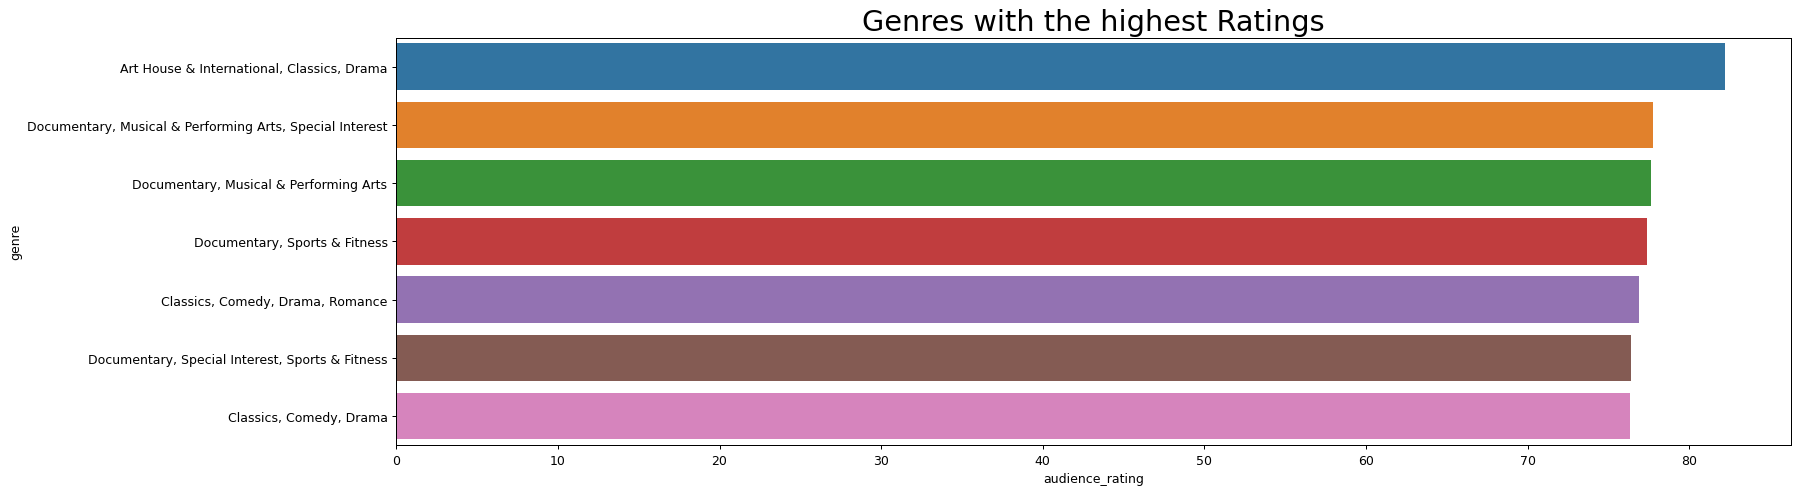

In [160]:
fig=plt.figure(figsize=(20,6),dpi=90,facecolor='w',edgecolor='k')

sns.barplot(y='genre',x= 'audience_rating',data=genera_rating_highest) \
  .set_title('Genres with the highest Ratings', fontSize=23)

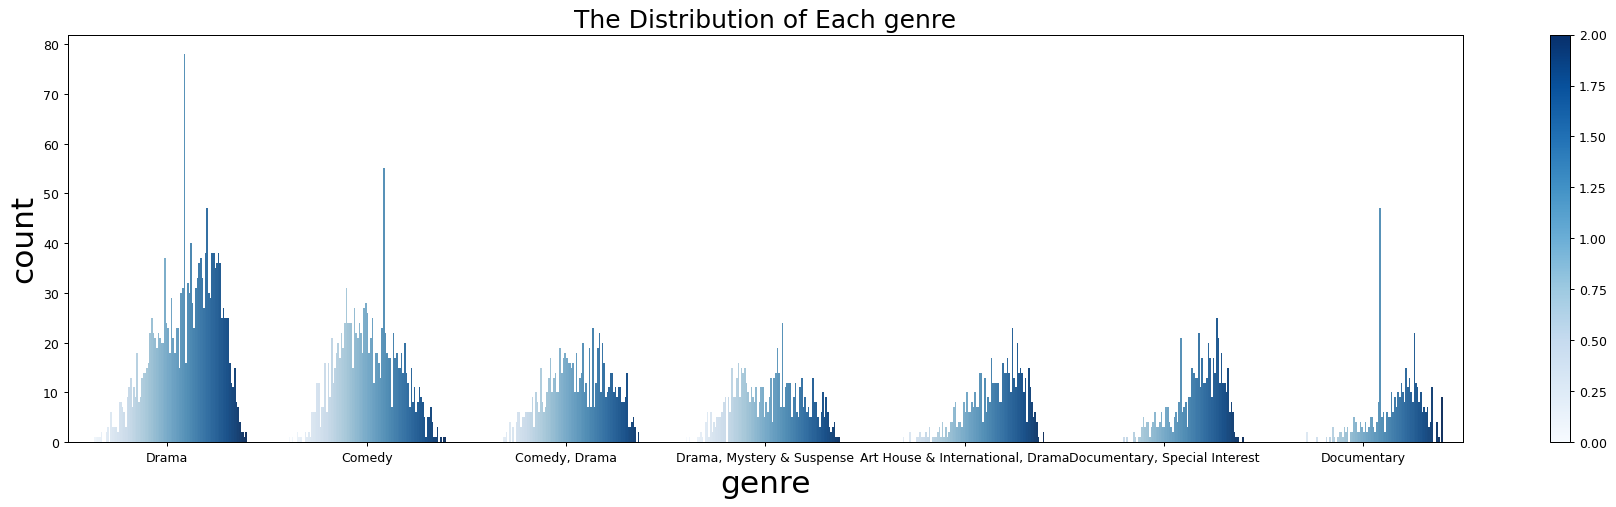

In [161]:
import matplotlib as mpl


fig=plt.figure(figsize=(25,6),dpi=90,facecolor='w',edgecolor='k')
cmap = sns.light_palette('purple', as_cmap=True)
ax = sns.countplot(x="genre", hue="audience_rating", data=result,
              palette='Blues', orientation='vertical',
              order=result.genre.value_counts(ascending=False).iloc[:7].index)

ax.legend_.remove()
plt.title('The Distribution of Each genre', fontSize='20')
ax.set_xlabel(ax.get_xlabel(), fontSize=25)
ax.set_ylabel(ax.get_ylabel(), fontSize=25)
norm = mpl.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([ax])
plt.colorbar(sm)


In [162]:
# import plotly.graph_objs as go
# trace = go.Histogram(x=result[result.genre == 'Drama'],xbins=1),marker=dict(color='rgb(0, 0, 100)')

# layout = go.Layout(
#     title="Histogram Frequency Counts"
# )

# fig = go.Figure(data=go.Data([trace]), layout=layout)
# py.iplot(fig, filename='histogram-freq-counts')

In [163]:
# fig, ax=plt.subplots(2, 1, figsize=(25,6))

# sns.distplot(data['audience_rating'], ax=ax[0])
# ax[0].axvline(df['audience_rating'].mean(),color='r')
# ax[0].axvline(df['audience_rating'].median(),color='g')
# ax[0].set_title('The Distribution of Audiance Rating', fontSize=23)


# sns.distplot(data['tomatometer_rating'], ax=ax[1])
# ax[1].axvline(df['tomatometer_rating'].mean(),color='r')
# ax[1].axvline(df['tomatometer_rating'].median(),color='g')
# ax[1].set_title('The Distribution of Tomatometer Rating', fontSize=23)

# plt.tight_layout()

In [164]:
data[['audience_rating','tomatometer_rating']]

,audience_rating,tomatometer_rating
0,53.0,49
1,64.0,86
2,53.0,68
3,97.0,100
4,74.0,89
...,...,...
16633,74.0,56
16634,92.0,97
16635,87.0,78
16636,91.0,95


In [165]:
import plotly.figure_factory as ff
data = data.dropna()
group_labels = data[['audience_rating','tomatometer_rating']].columns
fig = ff.create_distplot([data['audience_rating'],data['tomatometer_rating']], group_labels, bin_size=1)
fig.show()

## Time Series Analysis

In [166]:
class FeaturePicker(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._cols = cols

    @property
    def cols(self):
        return self._cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x[self._cols]

time_series_pipe = Pipeline([
    ('feature_picker', FeaturePicker(['in_theaters_date','on_streaming_date', 'tomatometer_status','audience_rating','tomatometer_rating'])),
])

ts_data = pipe.transform(data)

In [167]:
class TomatometerStatusDiscritizer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self._mapping = mapping
        pass

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        x['tomatometer_status'] = x['tomatometer_status'].map(self._mapping)
        return x

time_series_pipe = Pipeline([
    ('feature_picker', FeaturePicker(['in_theaters_date','on_streaming_date', 'tomatometer_status','audience_rating','tomatometer_rating'])),
    ('tomatometer_status_discritizer', TomatometerStatusDiscritizer({'Certified Fresh':3,'Fresh':2,'Rotten':1})),
])

ts_data = pipe.transform(data)

In [168]:
class TimeseriesMiscCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        x = x.dropna()
        x = x.set_index(x['in_theaters_date'])
        x['in_theaters_date'] = pd.to_datetime(x['in_theaters_date'])
        x['on_streaming_date'] = pd.to_datetime(x['on_streaming_date'])
        return x

time_series_pipe = Pipeline([
    ('feature_picker', FeaturePicker(['in_theaters_date','on_streaming_date', 'tomatometer_status','audience_rating','tomatometer_rating'])),
    ('tomatometer_status_discritizer', TomatometerStatusDiscritizer({'Certified Fresh':3,'Fresh':2,'Rotten':1})),
    ('timeseries_misc_cleaner', TimeseriesMiscCleaner()),
])

ts_data = time_series_pipe.transform(data)


In [169]:
ts_data.head(5)

,in_theaters_date,on_streaming_date,tomatometer_status,audience_rating,tomatometer_rating
in_theaters_date,,,,,
2010-02-12,2010-02-12,2010-06-29,1,53.0,49
2010-04-30,2010-04-30,2010-10-19,3,64.0,86
1957-04-13,1957-04-13,2001-03-06,3,97.0,100
1954-01-01,1954-01-01,2003-05-20,2,74.0,89
2008-03-07,2008-03-07,2008-06-24,1,37.0,8


In [170]:
ts_data_rotten = ts_data[ts_data.tomatometer_status == 1]
ts_data_fresh = ts_data[ts_data.tomatometer_status == 3]

In [171]:
import plotly.express as px
ts_data_rotten_plot = round((ts_data_rotten.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count()/ts_data.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count().replace(0, 1))*100,2)
ts_data_rotten_plot.dropna()

ts_data_fresh_plot = round((ts_data_fresh.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count()/ts_data.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count().replace(0, 1))*100,2)
ts_data_fresh_plot.dropna()

ts_data_plot = ts_data.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count()

ts_audience_plot=ts_data[['audience_rating','in_theaters_date']].groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count()
ts_rotten_plot=(ts_data_rotten[['tomatometer_rating','in_theaters_date']].groupby([pd.Grouper(key='in_theaters_date',freq='Y')]).count())/(ts_data[['tomatometer_rating','in_theaters_date']].groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count())*100
ts_fresh_plot=(ts_data_fresh[['tomatometer_rating','in_theaters_date']].groupby([pd.Grouper(key='in_theaters_date',freq='Y')]).count())/(ts_data[['tomatometer_rating','in_theaters_date']].groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).count())*100


In [172]:
fig = px.line(ts_data_plot, x=ts_data_plot.index, y="tomatometer_status", title='Total Movies Released')
fig.show()

In [173]:
fig = px.line(ts_rotten_plot, x=ts_rotten_plot.index, y="tomatometer_rating", title='Ratio of Rotten Tomatoes Released')
fig.show()

In [174]:
fig = px.line(ts_fresh_plot, x=ts_fresh_plot.index, y="tomatometer_rating", title='Ratio of Fresh Movies Released')
fig.show()

In [175]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ts_data_fresh_plot.index, y=ts_data_fresh_plot["tomatometer_status"],
                    mode='lines',
                    name='Ratio of Good Movies over the Years'))
fig.add_trace(go.Scatter(x=ts_data_rotten_plot.index, y=ts_data_rotten_plot["tomatometer_status"],
                    mode='lines+markers',
                    name='Ratio of Bad Movies over the Years'))

fig.update_layout(title='Ratio of Movies over the Years',
                   xaxis_title='Year',
                   yaxis_title='Ratio (%)')
fig.show()

In [176]:
ts_data_dummy = pd.get_dummies(ts_data['tomatometer_status'],prefix='tomatometer_status')
ts_df = pd.concat([ts_data,ts_data_dummy], axis=1)

In [177]:
ts_df_plot = ts_df.groupby([pd.Grouper(key='in_theaters_date', freq='Y')]).sum()
ts_df_plot.eval('tomatometer_status_total = tomatometer_status_1 + tomatometer_status_2 + tomatometer_status_3',inplace=True)

In [178]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ts_df_plot.index, y=ts_df_plot.tomatometer_status_1 / ts_df_plot.tomatometer_status_total * 100,
                    mode='lines',
                    name='The Percentage of Rotten Movies'))
fig.add_trace(go.Scatter(x=ts_df_plot.index, y=ts_df_plot.tomatometer_status_2 / ts_df_plot.tomatometer_status_total * 100,
                    mode='lines+markers',
                    name='The Percentage of Fresh Movies'))
fig.add_trace(go.Scatter(x=ts_df_plot.index, y=ts_df_plot.tomatometer_status_3 / ts_df_plot.tomatometer_status_total * 100,
                    mode='lines', name='The Percentage of CFresh Movies'))

fig.update_layout(title='The Percentage Status of Movies over the Years',
                   xaxis_title='Year',
                   yaxis_title='Percentage (%)')
fig.show()

## Cast and status


In [179]:
def cast_dict(status):
    df_status = df[df.tomatometer_status == status]
    list_status = [df_status.cast[i] for i in df_status.index if i != '']
    list_status = str(list_status).split(',')
    status_dict = Counter(list_status)
    return status_dict

In [180]:
Cfresh_dict = cast_dict('Certified Fresh')
fresh_dict = cast_dict('Fresh')
rotten_dict = cast_dict('Rotten')

In [181]:
cast_fresh = Cfresh_dict.copy()
cast_fresh.update(fresh_dict)

cast_fresh_sorted = sorted(cast_fresh.items(), key=operator.itemgetter(1),reverse=True)
names=[cast_fresh_sorted[i][0] for i in range(2,12)]
count=[cast_fresh_sorted[i][1] for i in range(2,12)]

Text(0.5, 1.0, 'Actors that appear in Hit movies')

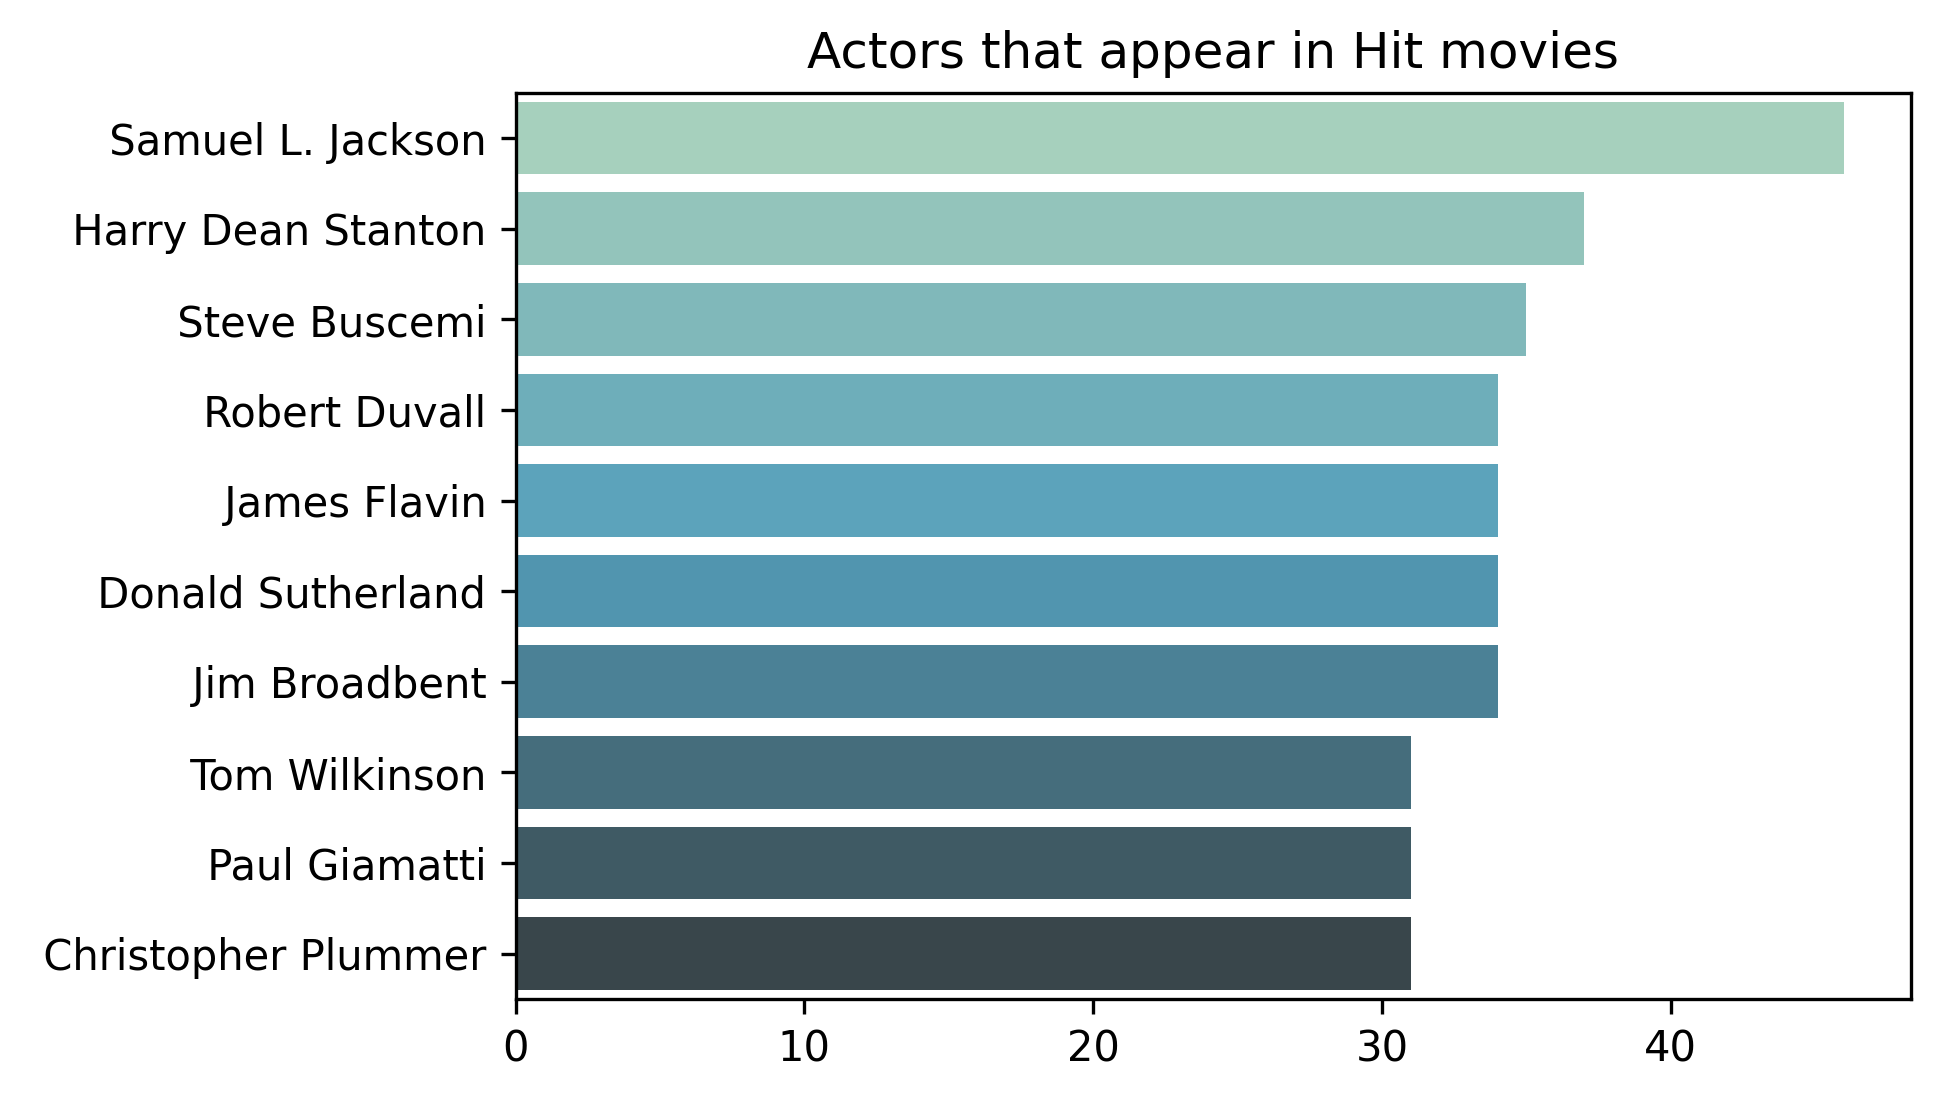

In [182]:
plt.figure(dpi=300)
sns.barplot(y=names,x=count,palette="GnBu_d").set_title('Actors that appear in Hit movies')

In [183]:
cast_rotten_sorted = sorted(rotten_dict.items(), key=operator.itemgetter(1),reverse=True)
cast_rotten_sorted[:11]

[(' Keith David', 47),
 (' Jr.', 43),
 (' Christopher McDonald', 41),
 (' Stephen Tobolowsky', 40),
 (' Peter Stormare', 38),
 (' Steve Buscemi', 37),
 (' Oliver Platt', 37),
 (' John Leguizamo', 37),
 (' John Goodman', 37),
 (' Stanley Tucci', 37),
 (' Richard Jenkins', 36)]

In [184]:
names=[cast_rotten_sorted[i][0] for i in range(0,11) if i !=1]
count=[cast_rotten_sorted[i][1] for i in range(0,11) if i !=1]

Text(0.5, 1.0, 'Actors that appear in rotten movies')

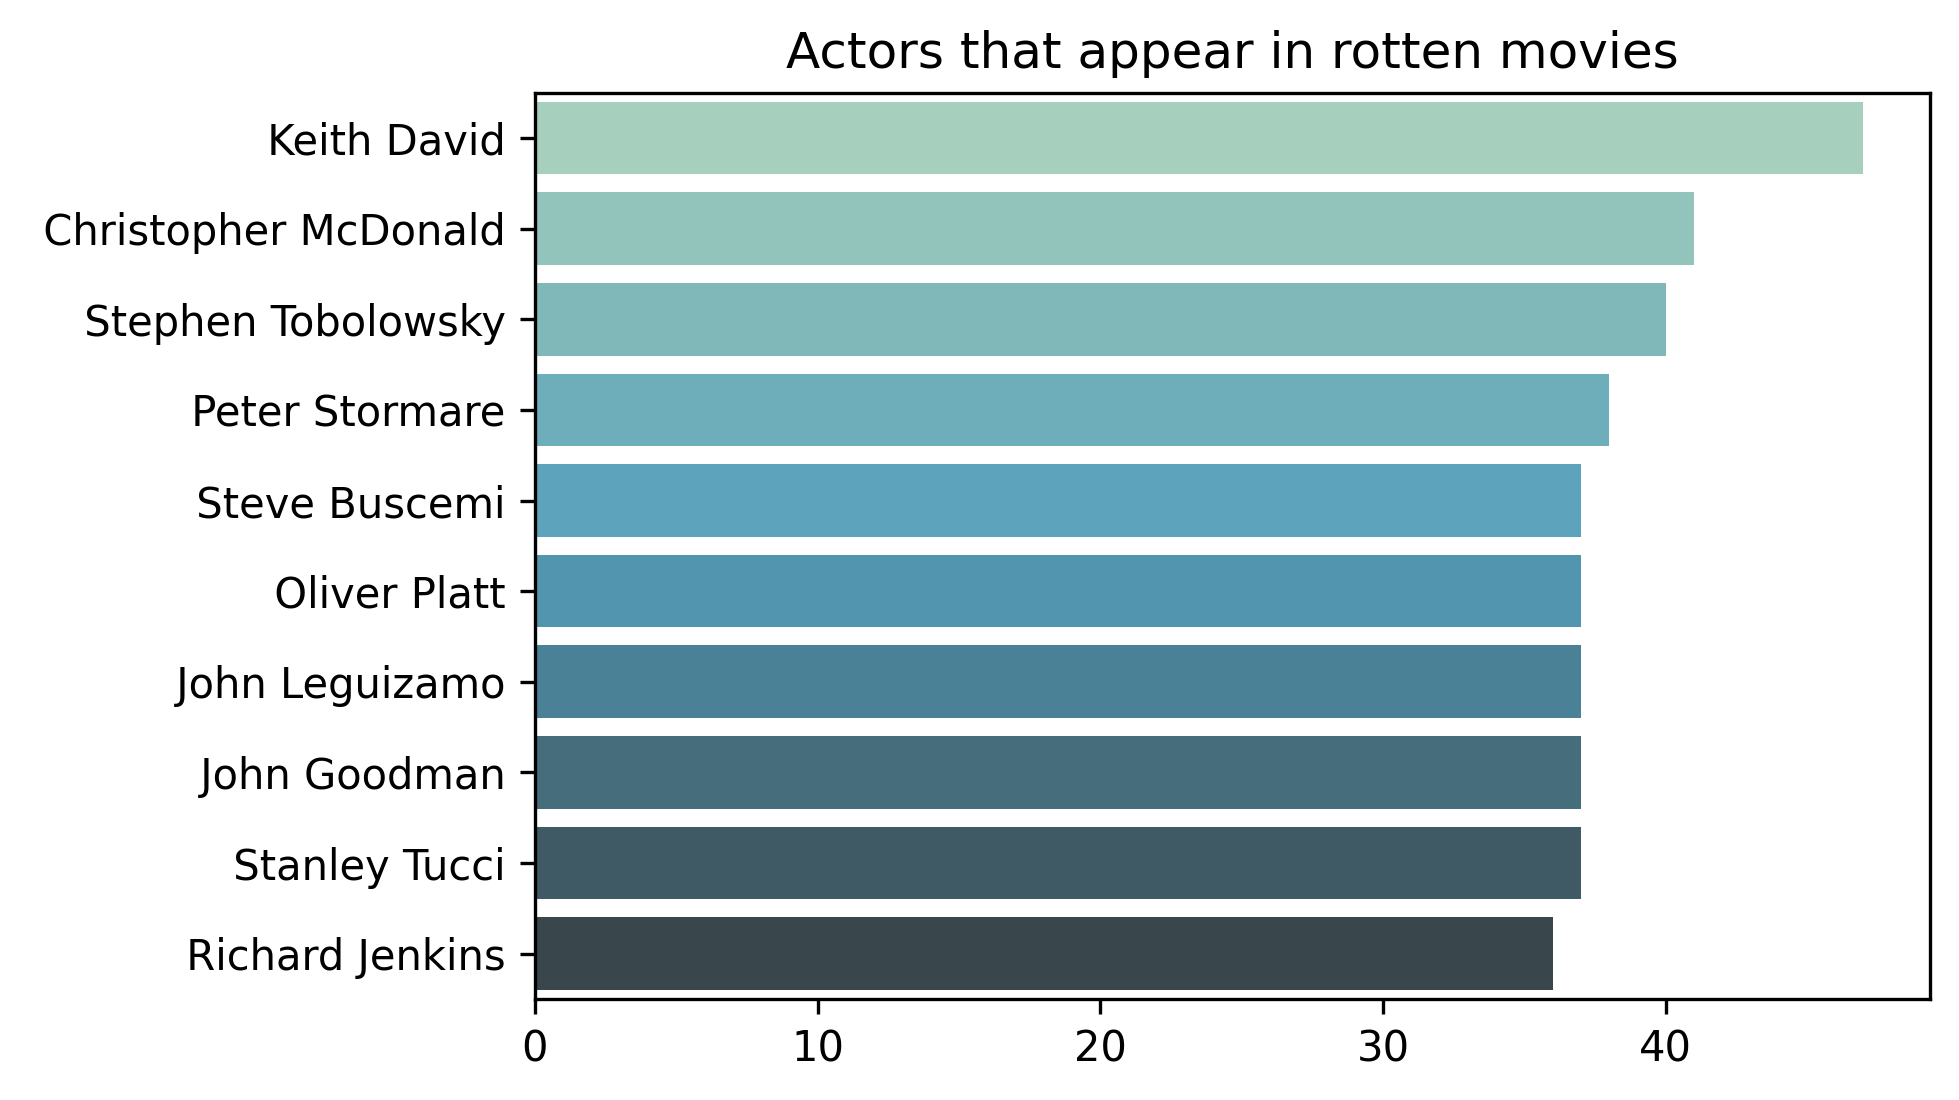

In [185]:
plt.figure(dpi=300)
sns.barplot(y=names,x=count,palette="GnBu_d").set_title('Actors that appear in rotten movies')

## Studio and status

In [186]:
def studio(status):
    df_status = data[data.tomatometer_status == status]
    status_studio = Counter(df_status.studio_name.tolist())
    status_studio = sorted(status_studio.items(), key=operator.itemgetter(1),reverse=True)
    df_studio = pd.DataFrame(status_studio, columns=['Studio_name', status]).set_index('Studio_name')
    return df_studio

In [187]:
Cfresh_studio = studio('Certified Fresh')
fresh_studio = studio('Fresh')
rotten_studio = studio('Rotten')
df_studio = pd.concat([Cfresh_studio,fresh_studio,rotten_studio], axis=1)
df_studio = df_studio.fillna(0)

In [188]:
fig = px.bar(df_studio.sort_values(by='Certified Fresh',ascending = False)[:10], y='Certified Fresh', x=df_studio.index[:10],title='The Top 10 Studios')
fig.show()

In [189]:
studio_sort=df_studio.sort_values(by='Rotten',ascending = False)
fig=px.bar(studio_sort[:10],y='Rotten',x=studio_sort.index[:10],title='Bottom 10 Studios')
fig.show()

## Genre and status

In [190]:
def genre_plot(status):
    df_status = data[data.tomatometer_status == status]
    genre_status = [df_status.genre[i] for i in df_status.index if i != '']
    data_list = str(genre_status).replace('&', ',')
    data_list = str(data_list).replace('\'', '')
    data_list = str(data_list).replace('[', ' ')
    data_list = str(data_list).replace(']', '')
    data_list = str(data_list).split(',')
    data_dict = Counter(data_list)
    for i,j in list(data_dict.items()):
        if j<500:
            data_dict['other'] +=j
            del data_dict[i]
    return data_dict

In [191]:
genre_Cfresh_dict = genre_plot('Certified Fresh')
genre_fresh_dict = genre_plot('Fresh')
genre_rotten_dict = genre_plot('Rotten')
genre_fresh = genre_Cfresh_dict.copy()
genre_fresh.update(genre_fresh_dict)
genre_fresh_sorted = sorted(genre_fresh.items(), key=operator.itemgetter(1),reverse=True)
genre_rotten_sorted = sorted(genre_rotten_dict.items(), key=operator.itemgetter(1),reverse=True)
genre_fresh_df = pd.DataFrame(genre_fresh_sorted, columns=['Genre', 'Counts'])
genre_rotten_df = pd.DataFrame(genre_rotten_sorted, columns=['Genre', 'Counts'])
fig = px.pie(genre_fresh_df, values='Counts', names='Genre')
fig.show()

In [192]:
fig = px.pie(genre_rotten_df, values='Counts', names='Genre')
fig.show()

## Rating and status

In [193]:
def rating_plot(status):
    df_status = data[data.tomatometer_status == status]
    df_status.rating = df_status.rating.str.replace(')','')
    status_rating = Counter(df_status.rating.tolist())
    status_rating = sorted(status_rating.items(), key=operator.itemgetter(1),reverse=True)
    status_rating = pd.DataFrame(status_rating, columns=['rating', status]).set_index('rating')
    return status_rating

In [194]:
Cfresh_rating = rating_plot('Certified Fresh')
fresh_rating = rating_plot('Fresh')
rotten_rating = rating_plot('Rotten')
df_rating = pd.concat([Cfresh_rating,fresh_rating,rotten_rating], axis=1)
df_rating = df_rating.fillna(0)
df_rating['New_Fresh'] = df_rating["Certified Fresh"] + df_rating['Fresh']

In [195]:
df_rating

,Certified Fresh,Fresh,Rotten,New_Fresh
R,1218,750,1455,1968
PG-13,511,325,1137,836
NR,417,357,129,774
PG,330,253,446,583
G,105,95,61,200
NC17,7,10,4,17


In [196]:
fig = px.pie(df_rating, values='New_Fresh', names=df_rating.index, title='The ratio of Rating in Fresh')
fig.show()

In [197]:
fig = px.pie(df_rating, values='Rotten', names=df_rating.index, title='The ratio of Rating in Rotten')
fig.show()

In [198]:
fig = px.pie(df_rating, values='Rotten', names=df_rating.index, title='The ratio of Rating in Rotten')
fig.show()

Data Preprocessing

In [199]:
df.rating.unique()

array(['PG', 'R', 'NR', 'G', 'PG-13', 'PG-13)', 'NC17', 'R)'],
      dtype=object)

In [200]:
class parentheseprocessed(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self._parentheseprocessed_col = col

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        x[self._parentheseprocessed_col]=x[self._parentheseprocessed_col].str.replace(')','')

        return x
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
])

result = pipe.transform(df)

In [201]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._remove_cols = cols

    @property
    def remove_cols(self):
        return self._remove_cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x.drop(self._remove_cols,axis=1)

pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus'])),
])

result = pipe.transform(df)

print(*result.columns, sep='\n')

rotten_tomatoes_link
movie_title
movie_info
poster_image_url
rating
genre
directors
writers
cast
in_theaters_date
on_streaming_date
runtime_in_minutes
studio_name
tomatometer_status
tomatometer_rating
tomatometer_count
audience_status
audience_rating
audience_count
audience_top_critics_count
audience_fresh_critics_count
audience_rotten_critics_count


In [202]:
# Codeblock
df.corr()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
runtime_in_minutes,1.000000,0.071497,0.189660,0.166238,0.049108,0.163732,0.189219,0.099372
tomatometer_rating,0.071497,1.000000,0.079565,0.655457,0.013926,0.049651,0.344220,-0.406547
tomatometer_count,0.189660,0.079565,1.000000,0.139727,0.132984,0.928250,0.902671,0.684753
audience_rating,0.166238,0.655457,0.139727,1.000000,0.022718,0.125957,0.310872,-0.216972
audience_count,0.049108,0.013926,0.132984,0.022718,1.000000,0.129845,0.125465,0.081870
audience_top_critics_count,0.163732,0.049651,0.928250,0.125957,0.129845,1.000000,0.805213,0.691071
audience_fresh_critics_count,0.189219,0.344220,0.902671,0.310872,0.125465,0.805213,1.000000,0.304512
audience_rotten_critics_count,0.099372,-0.406547,0.684753,-0.216972,0.081870,0.691071,0.304512,1.000000


Dropping Rotten Tomatoes Link and poster_image URL as it is a redundant column

In [203]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
])

result = pipe.transform(df)

print(*result.columns, sep='\n')

movie_title
movie_info
rating
genre
directors
writers
cast
in_theaters_date
on_streaming_date
runtime_in_minutes
studio_name
tomatometer_status
tomatometer_rating
tomatometer_count
audience_status
audience_rating
audience_count
audience_top_critics_count
audience_fresh_critics_count
audience_rotten_critics_count


In [204]:
df.corr()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
runtime_in_minutes,1.000000,0.071497,0.189660,0.166238,0.049108,0.163732,0.189219,0.099372
tomatometer_rating,0.071497,1.000000,0.079565,0.655457,0.013926,0.049651,0.344220,-0.406547
tomatometer_count,0.189660,0.079565,1.000000,0.139727,0.132984,0.928250,0.902671,0.684753
audience_rating,0.166238,0.655457,0.139727,1.000000,0.022718,0.125957,0.310872,-0.216972
audience_count,0.049108,0.013926,0.132984,0.022718,1.000000,0.129845,0.125465,0.081870
audience_top_critics_count,0.163732,0.049651,0.928250,0.125957,0.129845,1.000000,0.805213,0.691071
audience_fresh_critics_count,0.189219,0.344220,0.902671,0.310872,0.125465,0.805213,1.000000,0.304512
audience_rotten_critics_count,0.099372,-0.406547,0.684753,-0.216972,0.081870,0.691071,0.304512,1.000000


Dropping columns where directors,studio and writers are not present

In [205]:
class MissRowsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._affected_cols = cols

    @property
    def affected_cols(self):
        return self._affected_cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x.dropna(subset=self._affected_cols)

pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
])

result = pipe.transform(df)


In [206]:
result.shape

(14977, 20)

Grouping by Genre to find audience Rating

In [207]:
class GroupwiseMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, col_pairs):
        self._col_pairs = col_pairs

    @property
    def col_pairs(self):
        return self._col_pairs

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        for col, group in self._col_pairs.items():
            x[col] = x.groupby(group)[col].apply(lambda _x:_x.fillna(_x.median()))
        return x

pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
])

result = pipe.transform(df)

Imputing the rest by Median

In [208]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    
])

result = pipe.transform(df)

result.isnull().sum()

movie_title                        0
movie_info                         6
rating                             0
genre                             11
directors                          0
writers                            0
cast                              96
in_theaters_date                 572
on_streaming_date                  0
runtime_in_minutes                 0
studio_name                        0
tomatometer_status                 0
tomatometer_rating                 0
tomatometer_count                  0
audience_status                  156
audience_rating                    0
audience_count                     0
audience_top_critics_count         0
audience_fresh_critics_count       0
audience_rotten_critics_count      0
dtype: int64

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rotten_tomatoes_link           16638 non-null  object 
 1   movie_title                    16638 non-null  object 
 2   movie_info                     16614 non-null  object 
 3   critics_consensus              8309 non-null   object 
 4   poster_image_url               16638 non-null  object 
 5   rating                         16638 non-null  object 
 6   genre                          16621 non-null  object 
 7   directors                      16524 non-null  object 
 8   writers                        15289 non-null  object 
 9   cast                           16354 non-null  object 
 10  in_theaters_date               15823 non-null  object 
 11  on_streaming_date              16636 non-null  object 
 12  runtime_in_minutes             16638 non-null 

In [210]:

class BinningBuilder(BaseEstimator, TransformerMixin):
    def __init__(self, tar, dest, binnings, labels):
        self._tar = tar
        self._dest = dest
        self._binnings = binnings
        self._labels = labels

    @property
    def tar(self):
        return self._tar

    @property
    def dest(self):
        return self._dest

    @property
    def binning(self):
        return self._binnings

    @property
    def labels(self):
        return self._labels

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        x[self._dest] = pd.cut(x[self._tar], bins=self._binnings, labels=self._labels)
        return x



pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    
])

result = pipe.transform(df)


In [211]:
result['audience_status'].isnull().sum()

0

## OneHot encoding

In [212]:
class CustomizedOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._cols = cols

    @property
    def cols(self):
        return self._cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        for col in self._cols:
            data_dum = pd.get_dummies(x[col],prefix=col)
        for dummy_col in data_dum.columns:
            x[dummy_col] = data_dum[dummy_col]
        return x.drop(self._cols, axis=1)



pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    
])

result = pipe.transform(df)


In [213]:
result.columns

Index(['movie_title', 'movie_info', 'rating', 'genre', 'directors', 'writers',
       'cast', 'in_theaters_date', 'on_streaming_date', 'runtime_in_minutes',
       'studio_name', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_rating', 'audience_count',
       'audience_top_critics_count', 'audience_fresh_critics_count',
       'audience_rotten_critics_count', 'audience_status_Spilled',
       'audience_status_Upright'],
      dtype='object')

In [214]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),

])

result = pipe.transform(df)

Checking the data types of columns

In [215]:
result.dtypes

rating                            object
runtime_in_minutes               float64
tomatometer_status                object
audience_rating                  float64
audience_status_Spilled            uint8
audience_status_Upright            uint8
audience_count                   float64
audience_top_critics_count         int64
audience_fresh_critics_count       int64
audience_rotten_critics_count      int64
dtype: object

Removing Duplicate values 

In [216]:
class DuplicationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, subset_cols):
        self._subset_cols = subset_cols

    @property
    def subset_cols(self):
        return self._subset_cols

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x.drop_duplicates(subset=self._subset_cols,keep=False)


pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    
])

result = pipe.transform(df)

## Missing Value

In [217]:
result.isnull().sum()

rating                           0
runtime_in_minutes               0
tomatometer_status               0
audience_rating                  0
audience_status_Spilled          0
audience_status_Upright          0
audience_count                   0
audience_top_critics_count       0
audience_fresh_critics_count     0
audience_rotten_critics_count    0
dtype: int64

In [218]:
df.shape

(16638, 23)

- Convert feature rating into dummy variables

In [219]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count', 'audience_rating'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    ('customized_one_hot_encoding_2', CustomizedOneHotEncoding(['rating'])),
    
])

result = pipe.transform(df)


- Impute missing values in runtime_in_minutes with median

In [220]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count', 'audience_rating', 'runtime_in_minutes'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    ('customized_one_hot_encoding_rating', CustomizedOneHotEncoding(['rating'])),
])

result = pipe.transform(df)


In [221]:
class CustomizedTomatomesterStatusEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        x.loc[x['tomatometer_status']==2,'tomatometer_status']=1
        return x

pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count', 'audience_rating', 'runtime_in_minutes'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    ('customized_one_hot_encoding_rating', CustomizedOneHotEncoding(['rating'])),
    ('tomatometer_status_discritizer', TomatometerStatusDiscritizer({'Certified Fresh':2,'Fresh':1,'Rotten':0})),
    ('customized_tomatomester_status_encoder', CustomizedTomatomesterStatusEncoder()),

])

result = pipe.transform(df)

- Categorical variables can be converted to numerical variables with One-hot encoding to rank any sentiments present within the text.

In [222]:
# Codeblock





- Perform univariate analysis on attributes through the measure of dispersion, central tendency, and distribution.

In [223]:
# Codeblock



- Perform bivariate analysis of data and present the results to convey data visually across multiple attributes.

In [224]:
# Codeblock


### Conclusion part
- Descriptive statistics will be used to convey stories through visual insights thus systematizing the raw dataset in detail.

In [225]:
# Codeblock

# Modeling

- Setup Multi-thread parameter

In [226]:
import gc
import multiprocessing
cpu_cnt = multiprocessing.cpu_count()
allocated_cpu = cpu_cnt
print(f"Allocated {allocated_cpu} CPUs")
gc.collect()

Allocated 2 CPUs


56640

## Standardize Data

In [227]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count', 'audience_rating', 'runtime_in_minutes'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    ('customized_one_hot_encoding_rating', CustomizedOneHotEncoding(['rating'])),
    ('tomatometer_status_discritizer', TomatometerStatusDiscritizer({'Certified Fresh':2,'Fresh':1,'Rotten':0})),
    ('customized_tomatomester_status_encoder', CustomizedTomatomesterStatusEncoder()),

])

result = pipe.transform(df)


In [228]:
pipe = Pipeline([
    ('parentheseprocessed', parentheseprocessed('rating')),
    ('numerical_median_imputer', ColumnwiseMedianImputer(['audience_count', 'audience_rating', 'runtime_in_minutes'])),
    ('column_remover', ColumnRemover(['critics_consensus', 'rotten_tomatoes_link', 'poster_image_url'])),
    ('missing_rows_remover', MissRowsRemover(['directors','writers','studio_name'])),
    ('groupwise_median_imputer', GroupwiseMedianImputer({'audience_rating' : 'genre'})),
    ('numerical_median_imputer_2', ColumnwiseMedianImputer(['audience_rating'])),
    ('binning_builder', BinningBuilder('audience_rating', 'audience_status', [-10, 50, 101], ['Spilled', 'Upright'])),
    ('customized_one_hot_encoding', CustomizedOneHotEncoding(['audience_status'])),
    ('feature_picker', FeaturePicker(['rating',
                                      'runtime_in_minutes',
                                      'tomatometer_status',
                                      'audience_rating',
                                      'audience_status_Spilled',
                                      'audience_status_Upright',
                                      'audience_count',
                                      'audience_top_critics_count',
                                      'audience_fresh_critics_count',
                                      'audience_rotten_critics_count'])),
    ('duplication_remover', DuplicationRemover(["rating",
                                                "runtime_in_minutes",
                                                "tomatometer_status",
                                                "audience_rating",
                                                "audience_status_Spilled",
                                                "audience_status_Upright",
                                                "audience_count",
                                                "audience_top_critics_count",
                                                "audience_fresh_critics_count",
                                                "audience_rotten_critics_count"])),
    ('customized_one_hot_encoding_rating', CustomizedOneHotEncoding(['rating'])),
    ('tomatometer_status_discritizer', TomatometerStatusDiscritizer({'Certified Fresh':2,'Fresh':1,'Rotten':0})),
    ('customized_tomatomester_status_encoder', CustomizedTomatomesterStatusEncoder()),

])

result = pipe.transform(df)

## Create Splitting Dataset Function

In [229]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,x,y=None):
        return self

    def transform(self,x,y=None):
        return x

def split_IV_DV(df, preprocessing_pipeline=IdentityTransformer()):
    X = df.drop('tomatometer_status', axis=1)
    y = df['tomatometer_status']
    X = preprocessing_pipeline.fit(X).transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=seed)
    return (X_train, X_test, y_train, y_test)


## Regression Model

# 1.Logistic regression: 
On the basis of many explanatory variables we make a binary classification of whether a subscriber will like the movie or not.

In [230]:
# Codeblock
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import pickle

In [231]:

pipe =make_pipeline(StandardScaler())

X_train, X_test,y_train, y_test = split_IV_DV(result, pipe)
hyperparameters={'penalty': ['l1','l2'],
              'solver': ['liblinear','saga'],
                 'C':[0.001,0.0001],
                'max_iter':[1000]}

logistic=LogisticRegression()

cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logit_gs = GridSearchCV(estimator=logistic,param_grid=hyperparameters,cv=cv,verbose=0)
logit_gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.0001], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, ve

In [232]:
filename = 'finalized_logistic_model_C_1_L2.sav'
pickle.dump(logit_gs,open(filename,'wb'))
# load the model from disk

In [233]:
print (logit_gs.best_score_)
logit_best=logit_gs.best_estimator_
y_pred=logit_gs.predict(X_test)

0.8266714391750778


In [234]:
logit_best.score(X_train, y_train)

0.8304874558809501

In [235]:
lg_report = pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).transpose()
print(f"Precision:{round (metrics.precision_score(y_pred,y_test)*100)}%")
print(f"Recall : {round(metrics.recall_score(y_pred,y_test)*100)}%")
print(f"Accuracy: {round (metrics.accuracy_score(y_pred,y_test)*100)}%")
print(classification_report(y_pred,y_test))

Precision:88%
Recall : 84%
Accuracy: 84%
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1914
           1       0.88      0.84      0.86      2580

    accuracy                           0.84      4494
   macro avg       0.84      0.84      0.84      4494
weighted avg       0.84      0.84      0.84      4494



------------

ROC-Curve Logistic

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.923


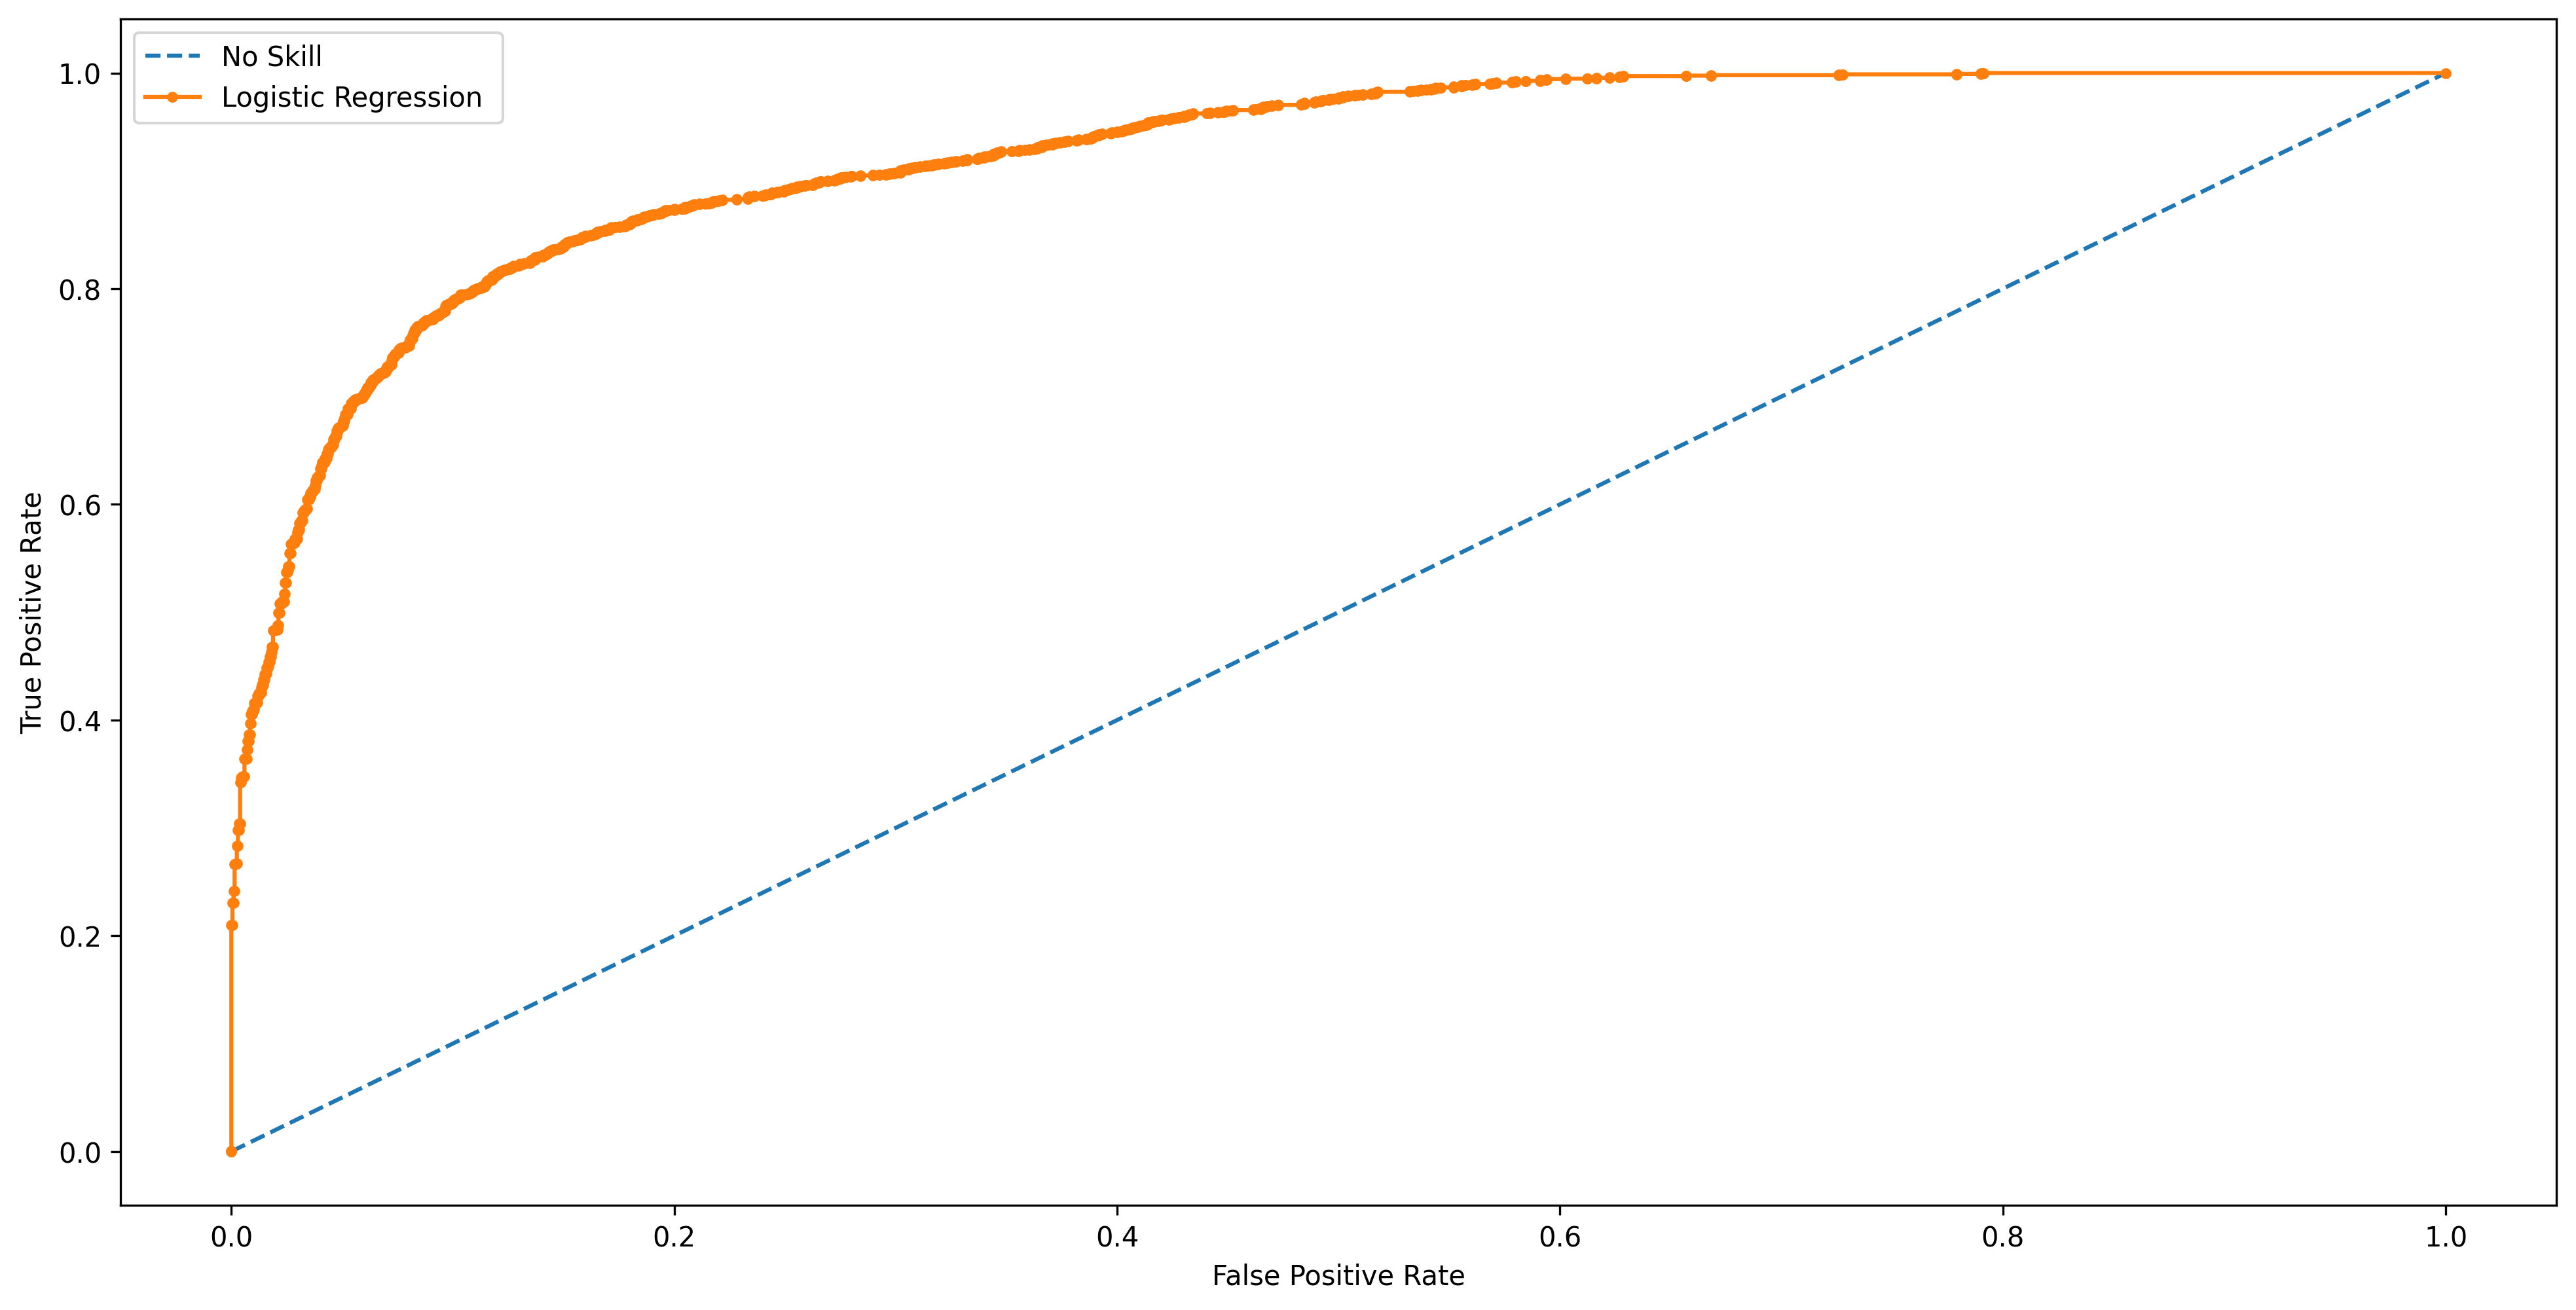

In [236]:
 # generate a no skill prediction (majority class)
noskill_prob = [0 for _ in range(len(X_test))]
 # predict probabilities
logit_prob = logit_best.predict_proba(X_test)
logit_prob = logit_prob[:,1]
 # calculating  scores
noskill_auc = roc_auc_score(y_test,noskill_prob)
logit_auc = roc_auc_score(y_test,logit_prob,average='macro')
 #Printing the summarized scores
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Logistic Regression : ROC AUC=%.3f' % (logit_auc))
 # calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_prob)
logit_fpr, logit_tpr, _ = roc_curve(y_test,logit_prob)
 # plot the roc curve for the model
plt.figure(figsize=(16,8),dpi=300)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(logit_fpr, logit_tpr, marker='.', label='Logistic Regression ')
# # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
# # show the plot
plt.show()


### 3.Random Forest: 


In [237]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

import pickle

n_estimators = number of trees in the foreset

max_features = max number of features considered for splitting a node

In [238]:
# Codeblock
cv = KFold(n_splits=3, shuffle=True)

X_train, X_test,y_train, y_test = split_IV_DV(result, pipe)
rf=RandomForestClassifier()
params={'n_estimators': range(80, 140,20),
                 'max_depth':range(3, 6),
              'max_features': range(3, 5),
       'criterion':['entropy']}

In [239]:
gs_rf=GridSearchCV(estimator=rf,param_grid=params,scoring="accuracy",n_jobs=-1,verbose=0)
gs_rf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [240]:
filename = 'finalized_rf_model_estimator_150_no_criterion.sav'
pickle.dump(gs_rf,open(filename,'wb'))

In [241]:
print (gs_rf.best_score_)
rf_best=gs_rf.best_estimator_
y_pred=rf_best.predict(X_test)

0.8823817740356089


In [242]:
rf_best.score(X_train, y_train)

0.8913478965944863

In [243]:
rf_best.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [244]:
X_train, X_test,y_train, y_test = split_IV_DV(result)
rf_feature = pd.DataFrame(zip(X_train.columns,rf_best.feature_importances_),columns=['features', 'importance'])
rf_feature.sort_values(by='importance', ascending = False)

,features,importance
7,audience_rotten_critics_count,0.290599
1,audience_rating,0.221204
6,audience_fresh_critics_count,0.214816
2,audience_status_Spilled,0.103357
3,audience_status_Upright,0.096467
10,rating_NR,0.025115
5,audience_top_critics_count,0.018022
4,audience_count,0.015523
12,rating_PG-13,0.008798
0,runtime_in_minutes,0.004585


In [245]:
rf_report = pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).transpose()
print(f"Precision Score:{round (metrics.precision_score(y_test,y_pred) *100)}%")
print(f"Recall Score:{round (metrics.recall_score(y_test,y_pred) *100)}%")
print(f"Accuracy Score:{round (metrics.accuracy_score(y_test,y_pred) *100)}%")
print(classification_report(y_test,y_pred))

Precision Score:89%
Recall Score:91%
Accuracy Score:89%
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2020
           1       0.89      0.91      0.90      2474

    accuracy                           0.89      4494
   macro avg       0.89      0.89      0.89      4494
weighted avg       0.89      0.89      0.89      4494



---------------

# ROC-Curve for Random-Forest
-----------

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.840


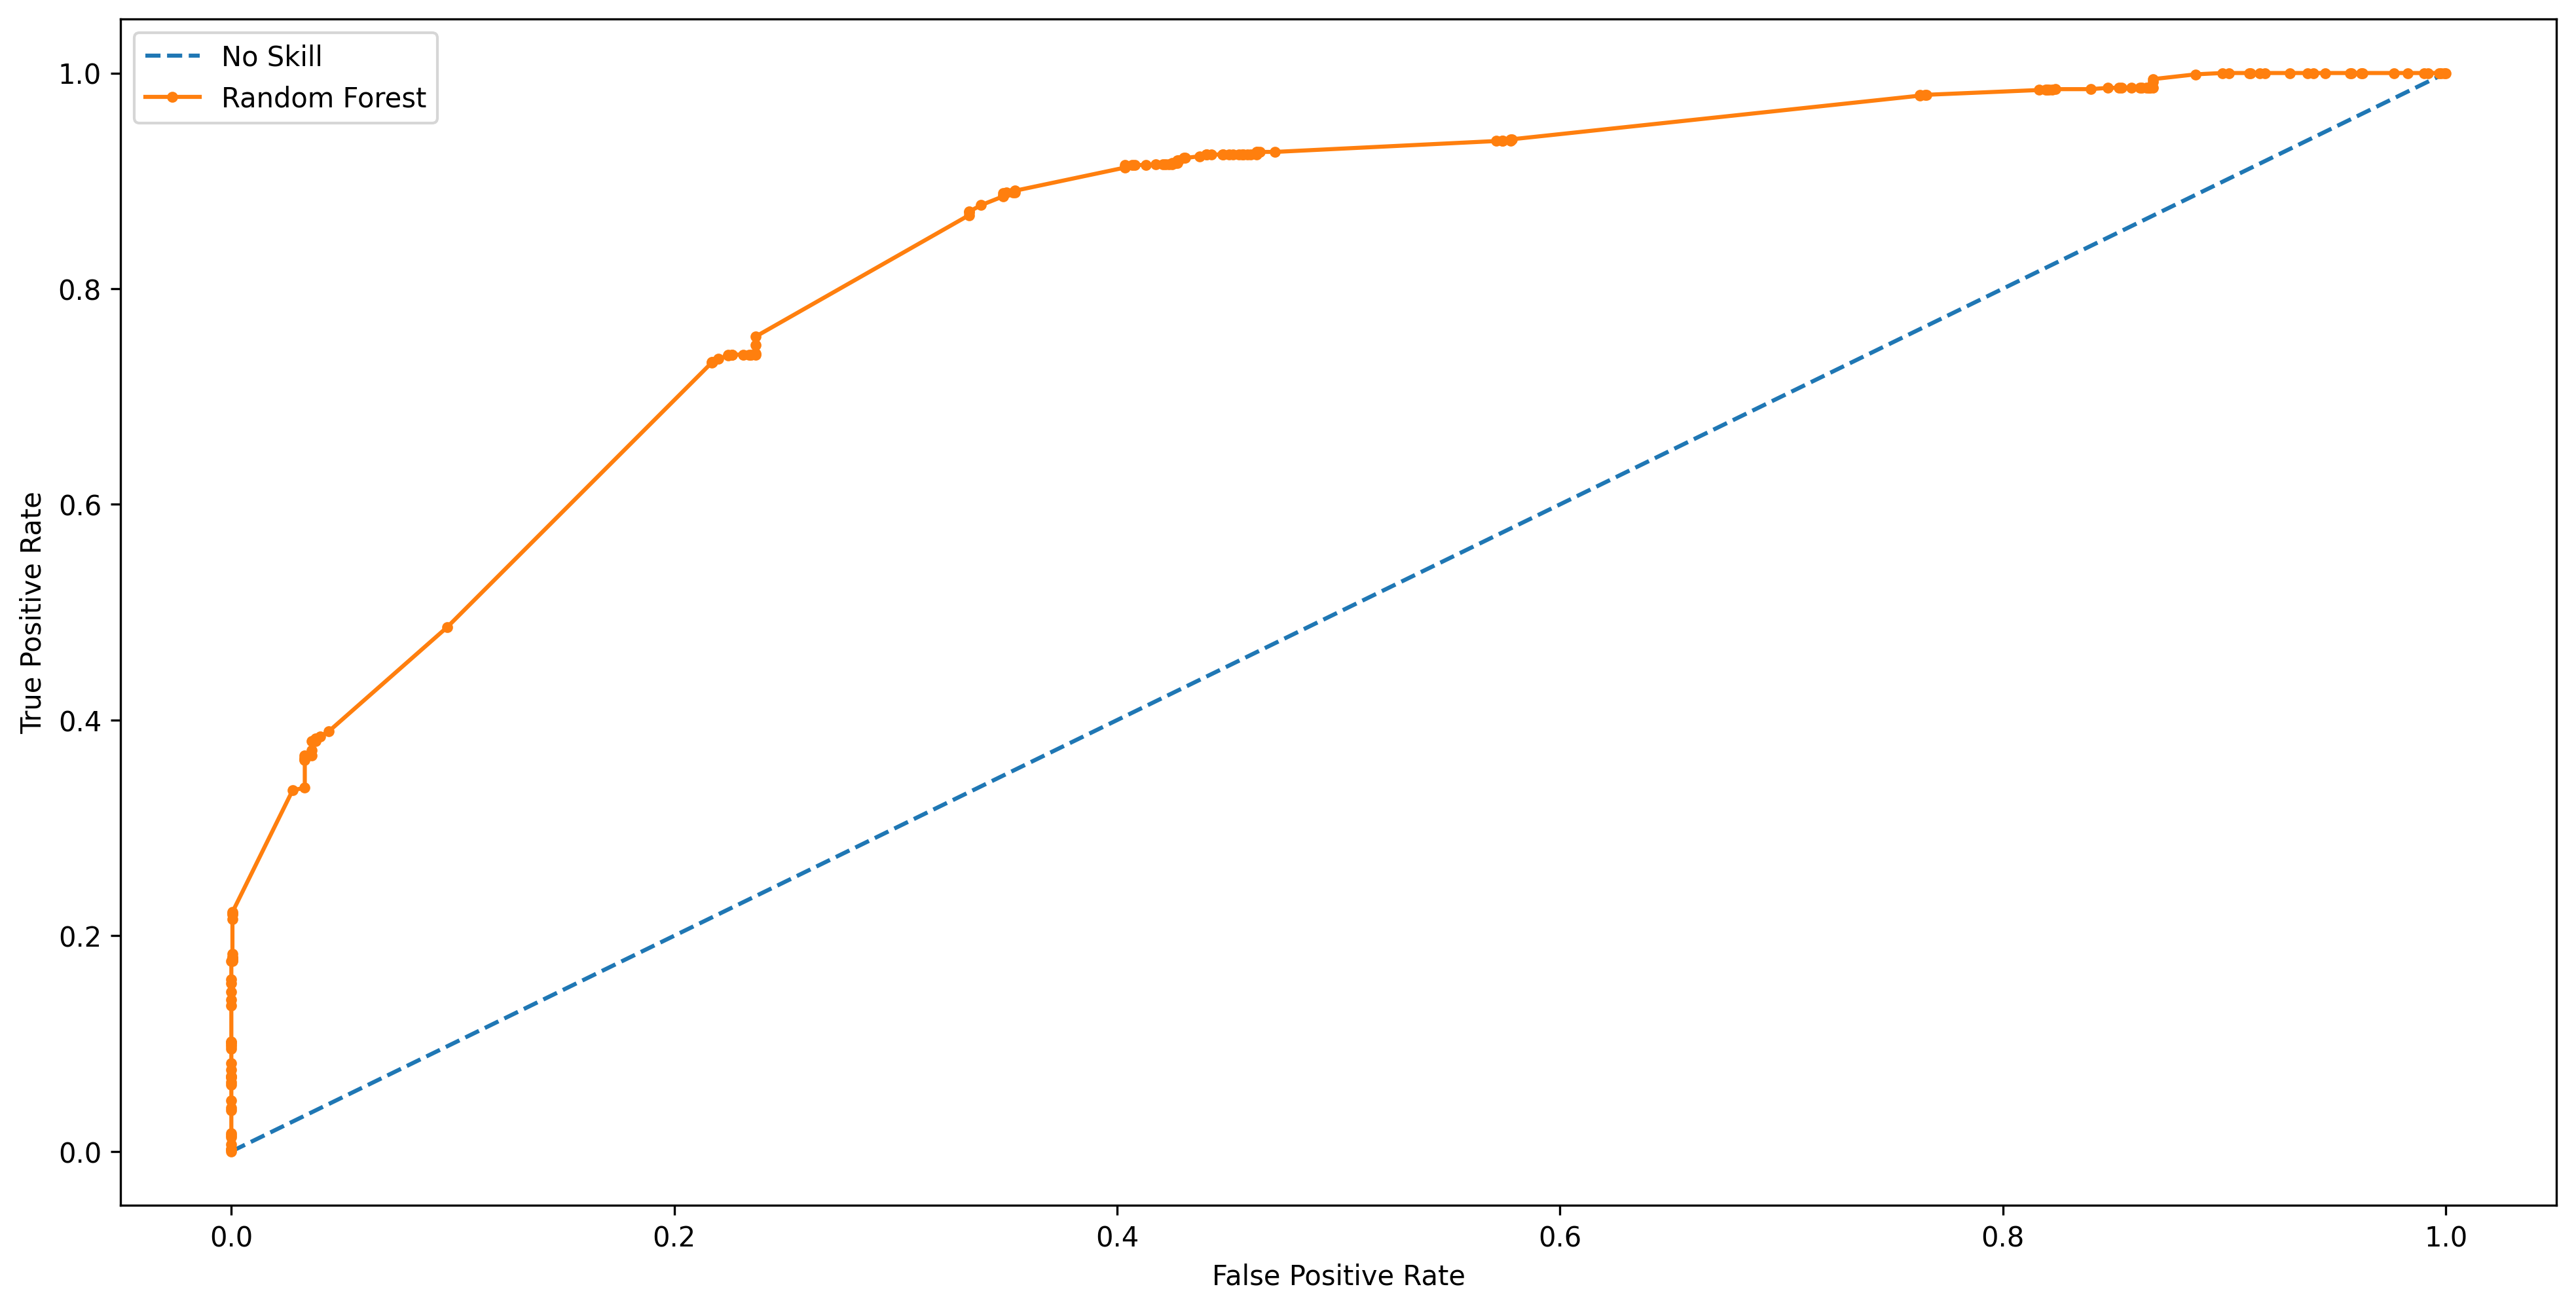

In [246]:
# generate a no skill prediction (majority class)
noskill_prob = [0 for _ in range(len(y_test))]

# predict probabilities
rf_prob = rf_best.predict_proba(X_test)
rf_prob = rf_prob[:,1]
# calculating  scores
noskill_auc = roc_auc_score(y_test,noskill_prob)
rf_auc = roc_auc_score(y_test,rf_prob,average='macro')
#Printing the summarized scores
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
# plot the roc curve for the model
plt.figure(figsize=(16,8),dpi=300)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


4.Gradient Boosting
------------------

In [247]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import StratifiedKFold

In [248]:
X_train, X_test,y_train, y_test = split_IV_DV(result, pipe)
cv=KFold(n_splits=10,shuffle=True,random_state=True)
# params={
#         'learning_rate' : [1],
#         'min_samples_leaf':[5],
#         'max_features':['auto']
#   }     
params={'learning_rate': np.arange(0.01, 0.09, 0.01),
              'n_estimators': range(10,50,10),
              'max_features':range(1, 3),
              }      
gbm=GradientBoostingClassifier()              
grid_search_gb= GridSearchCV(estimator=gbm, param_grid=params,scoring="accuracy",n_jobs=-1,cv=cv,verbose=0)
grid_search_gb.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=True, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weigh...
                                                  presort='deprecated',
                                

In [249]:
filename=("finalized_gb_learning_rate_1_min_leaf_5.sav")
pickle.dump(grid_search_gb,open(filename,"wb"))

In [250]:
for hps,values in  grid_search_gb.best_params_.items():
    print(f"{hps,values}")

gb_best=grid_search_gb.best_estimator_
gb_best.fit(X_train,y_train)

('learning_rate', 0.08)
('max_features', 2)
('n_estimators', 40)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.08, loss='deviance', max_depth=3,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=40,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [251]:
y_pred=gb_best.predict(X_test)

In [252]:
print (grid_search_gb.best_score_)

0.878946324744031


In [253]:
gb_best.score(X_train, y_train)

0.8835257082896117

In [254]:
print(f"Precision Score:{round (metrics.precision_score(y_test,y_pred,average='micro') *100)}%")
print(f"Recall Score:{round (metrics.recall_score(y_test,y_pred,average='micro') *100)}%")
print(f"Accuracy Score:{round (metrics.accuracy_score(y_test,y_pred) *100)}%")
print(classification_report(y_test,y_pred))
gbt_report = pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).transpose()

Precision Score:88%
Recall Score:88%
Accuracy Score:88%
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      2020
           1       0.88      0.90      0.89      2474

    accuracy                           0.88      4494
   macro avg       0.88      0.88      0.88      4494
weighted avg       0.88      0.88      0.88      4494



ROC-Curve--Gradient Boosting
-----------

No Skill: ROC AUC=0.500
Gradient Boosting: ROC AUC=0.955


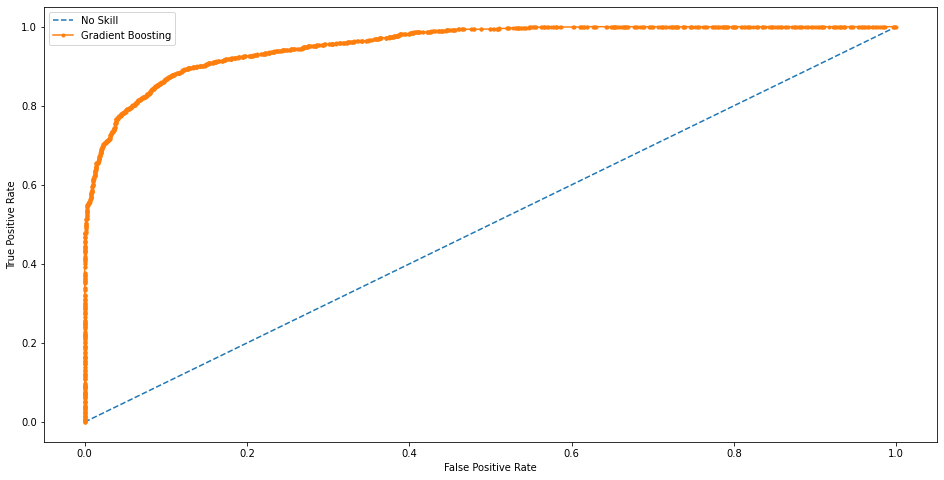

In [255]:
# generate a no skill prediction (majority class)
noskill_prob = [0 for _ in range(len(y_test))]

# predict probabilities
gb_prob = gb_best.predict_proba(X_test)
gb_prob = gb_prob[:, 1]
# calculating  scores
noskill_auc = roc_auc_score(y_test,noskill_prob)
gb_auc = roc_auc_score(y_test,gb_prob)
#Printing the summarized scores
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Gradient Boosting: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_prob)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_prob)
# plot the roc curve for the model
plt.figure(figsize=(16,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosting')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [256]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'learning_rate': np.arange(0.01, 0.2, 0.05),
#               'n_estimators': range(50, 200,10),
#               'max_features':range(1, 10),
#               'max_depth': range(2, 5)}
# clf = GridSearchCV(gbm(), param_grid)
# clf.fit(X_train_std, y_train)
# print(f"Accuracy for best GBM: {round(clf.best_score_*100, 2)}%")

5.Clustering: 
----------
Grouping audience into different clusters for the purpose of targeting them with similar labels of movies, measuring accuracy of clustering classification as opposed to naive Bayes which computes the probabilistic score of the likelihood of watching a movie.

In [257]:
# Codeblock
pipe=Pipeline([('standardizer',StandardScaler()),])
X_train,X_test,y_train,y_test=split_IV_DV(result,pipe)

In [258]:
error=[]
for i in range(1,35):
    knn=neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred=knn.predict(X_test)
    error.append(np.mean(y_pred!=pred))

Text(0, 0.5, 'Mean Error')

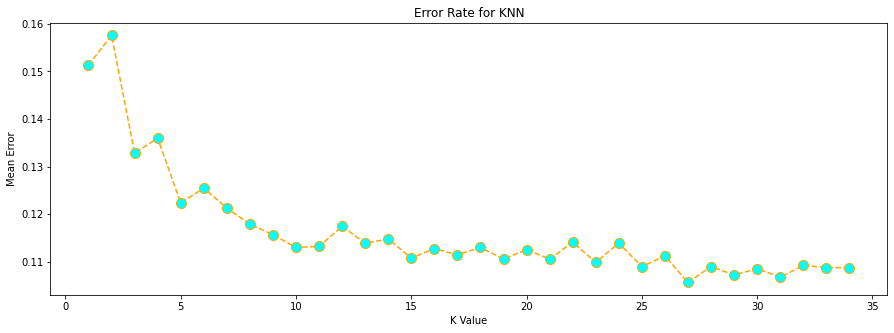

In [259]:
plt.figure(figsize=(15,5))
plt.plot(range(1, 35), error, color='orange',linestyle='dashed',marker='o',
         markerfacecolor='cyan', markersize=10)
plt.title("Error Rate for KNN")
plt.xlabel("K Value")
plt.ylabel("Mean Error")

Set p = 1 then it will use the Manhattan distance and p = 2 to be Euclidean.

In [260]:
param_grid={'weights': ['distance'],
              'algorithm': ['brute'], 
              'p': [2],
          }
knn=neighbors.KNeighborsClassifier(n_neighbors=3)
cv=StratifiedKFold(n_splits=5,shuffle=True)
grid_search_knn=GridSearchCV(estimator=knn,param_grid=param_grid,n_jobs=allocated_cpu,verbose=0,cv=cv)
grid_search_knn.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'algorithm': ['brute'], 'p': [2],
                         'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [261]:
filename=("finalized_knn_algo_brute_p_2.sav")
pickle.dump(grid_search_knn,open(filename,"wb"))

In [262]:
for hps,values in grid_search_knn.best_params_.items():
    print(f"{hps,values}")

knn_best=grid_search_knn.best_estimator_ 
knn_best.fit(X_train,y_train) 
print(y_test.shape)
y_pred=knn_best.predict(X_test)


('algorithm', 'brute')
('p', 2)
('weights', 'distance')
(4494,)


In [263]:
knn_report = pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).transpose()
print(f"Precision:{round (metrics.precision_score(y_pred,y_test)*100)}%")
print(f"Recall : {round(metrics.recall_score(y_pred,y_test)*100)}%")
print(f"Accuracy : {round(metrics.accuracy_score(y_pred,y_test)*100)}%")
print(classification_report(y_pred,y_test))

Precision:90%
Recall : 92%
Accuracy : 90%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2061
           1       0.90      0.92      0.91      2433

    accuracy                           0.90      4494
   macro avg       0.90      0.90      0.90      4494
weighted avg       0.90      0.90      0.90      4494



ROC-CURVE-KNN
-------------

No Skill: ROC AUC=0.500
Knn : ROC AUC=0.958


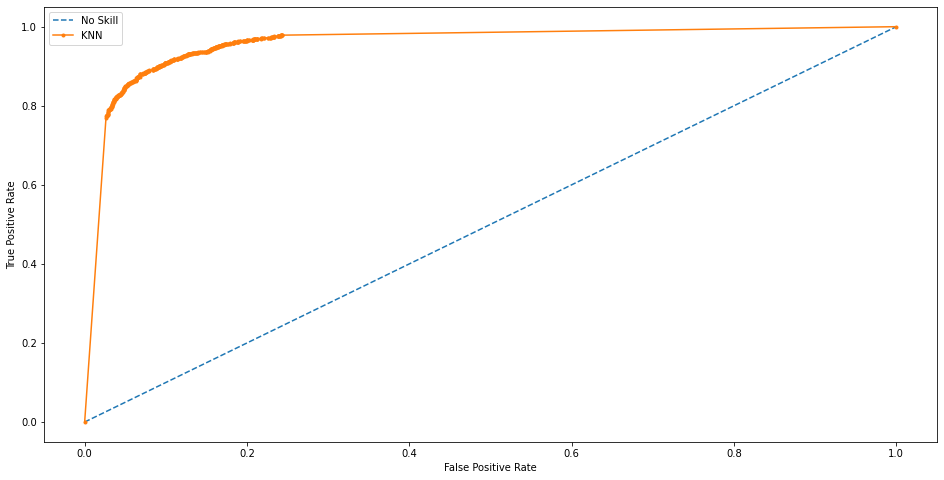

In [264]:
# generate a no skill prediction (majority class)
noskill_prob = [0 for _ in range(len(X_test))]

# predict probabilities
knn_prob = knn_best.predict_proba(X_test)
knn_prob = knn_prob[:, 1]
# calculating  scores
noskill_auc = roc_auc_score(y_test,noskill_prob)
knn_auc = roc_auc_score(y_test, knn_prob)
# Printing the summarized scores
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Knn : ROC AUC=%.3f' % (knn_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob)
# plot the roc curve for the model
plt.figure(figsize=(16,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

6.Association Rule Mining
-------

Assigning values to a new data frame

In [265]:
df=data.copy()

In [266]:
df_association=df.copy()
df_association.head(3)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0


In [267]:
df_association.drop(['cast','critics_consensus','movie_title','rotten_tomatoes_link','movie_info','poster_image_url'],axis=1,inplace=True)

**Binning Categorical Variables on the basis of Tomatometer Ratings and Audience Count**

In [268]:
print(df_association['audience_top_critics_count'].min())
print(df_association['audience_top_critics_count'].max())
print(df_association['audience_top_critics_count'].median())

df_association['audience_top_critics_count'].describe()

0
64
24.0


count    7610.000000
mean       25.380158
std        14.544421
min         0.000000
25%        13.000000
50%        24.000000
75%        37.000000
max        64.000000
Name: audience_top_critics_count, dtype: float64

In [269]:
labels=('Disliked_Genre','Watchable_Genre','Famous_Genre')
df_association['genre_label']=pd.cut(df_association['audience_top_critics_count'],bins=(0,13,37,64),labels=labels)


In [270]:
labels=('Dull_Studio','Regular_Studio','Famous _Studio')
df_association['studio_label']=pd.cut(df_association['audience_top_critics_count'],bins=(0,13,37,64),labels=labels)

 **The Longest movie ever made ran a total of 773 minutes
Thus we need to winsorize the column**

In [271]:
df_association['runtime_in_minutes']=df_association['runtime_in_minutes'].clip(upper=773)

In [272]:
print(df_association['runtime_in_minutes'].describe().loc['min'])
print(df_association['runtime_in_minutes'].describe().loc['25%'])
print(df_association['runtime_in_minutes'].describe().loc['50%'])
print(df_association['runtime_in_minutes'].describe().loc['75%'])
print(df_association['runtime_in_minutes'].describe().loc['max'])

1.0
94.0
103.0
116.0
333.0


**Discretizing Variables on the basis of rotten tomato rating**
Binning Writers Directors and Studio Labels on the bais of audeince ratings

In [273]:
labels=('Rotten_Director','Regular_Director','Famous_Director')
df_association['Director_Status']=pd.qcut(df_association['audience_top_critics_count'],labels=labels,q=3)

labels=('Rotten_Writer','Regular_Writer','Famous_Writer')
df_association['Writer_status']=pd.qcut(df_association['audience_top_critics_count'],labels=labels,q=3)

Assuming that an averge movie runs from 1 to 3 hours 

In [274]:
labels=('Short_Runtime','Average_Time','Long_Runtime')
df_association['movie_runtime']=pd.cut(df_association['runtime_in_minutes'],bins=(0,60,180,773),labels=labels)

In [275]:
print(df_association['audience_count'].describe().loc['min'])
print(df_association['audience_count'].describe().loc['25%'])
print(df_association['audience_count'].describe().loc['50%'])
print(df_association['audience_count'].describe().loc['75%'])
print(df_association['audience_count'].describe().loc['max'])

5.0
6042.0
25235.5
94800.75
35797635.0


In [276]:
labels=('Rotten_Count','Regular_Count','Filled_Count')
df_association['audience_count_label']=pd.qcut(df_association['audience_count'],q=3,labels=labels)

labels=('Rotten_Count','Regular_Count','Filled_Count')
df_association['audience_count_label']=pd.qcut(df_association['audience_count'],q=3,labels=labels)

In [277]:
df_association.drop(['genre','directors','writers','in_theaters_date','on_streaming_date','studio_name','audience_count'],axis=1,inplace=True)

In [278]:
def create_dummies(col_name):
    dumdf=pd.get_dummies(df_association[col_name])
    dumdf.columns=[col_name+"_"+str(col) for col in dumdf.columns]
    return dumdf  

In [279]:
df_association.dtypes

rating                             object
runtime_in_minutes                float64
tomatometer_status                 object
tomatometer_rating                  int64
tomatometer_count                   int64
audience_status                    object
audience_rating                   float64
audience_top_critics_count          int64
audience_fresh_critics_count        int64
audience_rotten_critics_count       int64
genre_label                      category
studio_label                     category
Director_Status                  category
Writer_status                    category
movie_runtime                    category
audience_count_label             category
dtype: object

In [280]:
df_association['genre_label']=df_association['genre_label'].astype(object)
df_association['studio_label']=df_association['studio_label'].astype(object)
df_association['Director_Status']=df_association['Director_Status'].astype(object)
df_association['Writer_status']=df_association['Writer_status'].astype(object)
df_association['movie_runtime']=df_association['movie_runtime'].astype(object)

In [281]:
ratingDum=create_dummies('rating')
dumdf_1=df_association.drop('rating',axis=1).join(ratingDum)

tomatometer_statusDum=create_dummies('tomatometer_status')
dumdf_1=dumdf_1.drop('tomatometer_status',axis=1).join(tomatometer_statusDum)

audience_statusDum=create_dummies('audience_status')
dumdf_1=dumdf_1.drop('audience_status',axis=1).join(audience_statusDum)

In [282]:
genre_labelDum=create_dummies('genre_label')
dumdf_1=dumdf_1.drop('genre_label',axis=1).join(genre_labelDum)

studio_labelDum=create_dummies('studio_label')
dumdf_1=dumdf_1.drop('studio_label',axis=1).join(studio_labelDum)

Director_StatusDum=create_dummies('Director_Status')
dumdf_1=dumdf_1.drop('Director_Status',axis=1).join(Director_StatusDum)

Writer_statusDum=create_dummies('Writer_status')
dumdf_1=dumdf_1.drop('Writer_status',axis=1).join(Writer_statusDum)

movie_runtimeDum=create_dummies('movie_runtime')
dumdf_1=dumdf_1.drop('movie_runtime',axis=1).join(movie_runtimeDum)


In [283]:
audience_countDum=create_dummies('audience_count_label')
dumdf_1=dumdf_1.drop('audience_count_label',axis=1).join(audience_countDum)

In [284]:
dumdf_1.head()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_PG-13),rating_R,rating_R),tomatometer_status_Certified Fresh,tomatometer_status_Fresh,tomatometer_status_Rotten,audience_status_Spilled,audience_status_Upright,genre_label_Disliked_Genre,genre_label_Famous_Genre,genre_label_Watchable_Genre,studio_label_Dull_Studio,studio_label_Famous _Studio,studio_label_Regular_Studio,Director_Status_Famous_Director,Director_Status_Regular_Director,Director_Status_Rotten_Director,Writer_status_Famous_Writer,Writer_status_Regular_Writer,Writer_status_Rotten_Writer,movie_runtime_Average_Time,movie_runtime_Long_Runtime,movie_runtime_Short_Runtime,audience_count_label_Rotten_Count,audience_count_label_Regular_Count,audience_count_label_Filled_Count
0,83.0,49,144,53.0,38,71,73,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1
1,90.0,86,140,64.0,43,121,19,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,95.0,100,51,97.0,6,51,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1
4,127.0,89,27,74.0,5,24,3,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1
5,109.0,8,148,37.0,36,12,136,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1


In [285]:
df_association.drop(['runtime_in_minutes'],axis=1,inplace=True)
df_association.drop(['audience_fresh_critics_count','audience_top_critics_count','audience_rotten_critics_count'],axis=1,inplace=True)

In [286]:
df_association.drop(['tomatometer_rating','tomatometer_count','audience_rating'],axis=1,inplace=True)

Preparing Data for association Rule Mining

In [287]:
# convert dataframe to string
df_association= df_association.astype('str')

In [288]:
# Strip whitespaces
df_association[df_association.columns] = df_association.apply(lambda x: x.str.strip())

In [289]:
#Convert to type object
df_association = df_association.astype('object')

In [290]:
categorical_data = df_association.select_dtypes(include=['object'])
categorical_data = categorical_data.apply(lambda col: col.apply(lambda element: f"{col.name}={element}"))
categorical_data.head(5)

,rating,tomatometer_status,audience_status,genre_label,studio_label,Director_Status,Writer_status,movie_runtime,audience_count_label
0,rating=PG,tomatometer_status=Rotten,audience_status=Spilled,genre_label=Famous_Genre,studio_label=Famous _Studio,Director_Status=Famous_Director,Writer_status=Famous_Writer,movie_runtime=Average_Time,audience_count_label=Filled_Count
1,rating=R,tomatometer_status=Certified Fresh,audience_status=Upright,genre_label=Famous_Genre,studio_label=Famous _Studio,Director_Status=Famous_Director,Writer_status=Famous_Writer,movie_runtime=Average_Time,audience_count_label=Regular_Count
3,rating=NR,tomatometer_status=Certified Fresh,audience_status=Upright,genre_label=Disliked_Genre,studio_label=Dull_Studio,Director_Status=Rotten_Director,Writer_status=Rotten_Writer,movie_runtime=Average_Time,audience_count_label=Filled_Count
4,rating=G,tomatometer_status=Fresh,audience_status=Upright,genre_label=Disliked_Genre,studio_label=Dull_Studio,Director_Status=Rotten_Director,Writer_status=Rotten_Writer,movie_runtime=Average_Time,audience_count_label=Filled_Count
5,rating=PG-13,tomatometer_status=Rotten,audience_status=Spilled,genre_label=Watchable_Genre,studio_label=Regular_Studio,Director_Status=Famous_Director,Writer_status=Famous_Writer,movie_runtime=Average_Time,audience_count_label=Filled_Count


In [291]:
# Create a list out of the dataframe
records = []
for i in range(0,len(categorical_data)):
    records.append([str(categorical_data.values[i,j]) 
    for j in range(0, len(categorical_data.columns))])

In [292]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
#initialize transaction encoder
te = TransactionEncoder()
# Transform records
te_ary = te.fit(records).transform(records)
#convert the transformed records to a dataframe
df2 = pd.DataFrame(te_ary, columns=te.columns_)

In [293]:
df2.head()

,Director_Status=Famous_Director,Director_Status=Regular_Director,Director_Status=Rotten_Director,Writer_status=Famous_Writer,Writer_status=Regular_Writer,Writer_status=Rotten_Writer,audience_count_label=Filled_Count,audience_count_label=Regular_Count,audience_count_label=Rotten_Count,audience_status=Spilled,audience_status=Upright,genre_label=Disliked_Genre,genre_label=Famous_Genre,genre_label=Watchable_Genre,genre_label=nan,movie_runtime=Average_Time,movie_runtime=Long_Runtime,movie_runtime=Short_Runtime,rating=G,rating=NC17,rating=NR,rating=PG,rating=PG-13,rating=PG-13),rating=R,rating=R),studio_label=Dull_Studio,studio_label=Famous _Studio,studio_label=Regular_Studio,studio_label=nan,tomatometer_status=Certified Fresh,tomatometer_status=Fresh,tomatometer_status=Rotten
0,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,True,False,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False
2,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True


In [294]:
# Create frequent itemsets using apriori
frequent_itemsets = apriori(df2,use_colnames=True)

In [295]:
frequent_itemsets.sort_values(by='support',ascending=False).head(6)

,support,itemsets
1,0.989882,(movie_runtime=Average_Time)
0,0.586334,(audience_status=Upright)
2,0.577530,"(movie_runtime=Average_Time, audience_status=U..."


In [296]:
#Create Association Rules
rules = association_rules(frequent_itemsets)
rules.sort_values(by = 'lift',ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(audience_status=Upright),(movie_runtime=Average_Time),0.586334,0.989882,0.57753,0.984984,0.995053,-0.002872,0.673846


In [297]:
# Function to set consequents and run association rules
def SupervisedApriori(data,consequent,min_supp,min_conf,min_lift):
    frequent_itemsets = apriori(data, min_supp, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
    #filter according to lift
    rules = rules[rules['lift'] > min_lift]
    sup_rules = pd.DataFrame()
    for i in consequent:
        df = rules[rules['consequents'] == {i}]
        sup_rules = sup_rules.append(df,ignore_index = True)
    return(sup_rules)

**The below rules are the 5 most interesting because they have the highest lift(values >1). **

**Rules for  a movie to be a Certified Fresh Movie**

**For a movie to be critically succesfull  it should be directed by a reverred director or a famous writer that is able to communicate his story** 

**Also the audiences should enjoy the movie showing that audience and critic opinion match**

In [298]:
movie_Cfresh = SupervisedApriori(df2,consequent = ['tomatometer_status=Certified Fresh'],
min_supp=0.11, min_conf=0.41, min_lift=1)
movie_Cfresh.sort_values(by="lift",ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
25,"(movie_runtime=Average_Time, audience_status=U...",(tomatometer_status=Certified Fresh),0.202102,0.340079,0.132457,0.655397,1.927190,0.063727,1.915016
38,"(movie_runtime=Average_Time, Writer_status=Fam...",(tomatometer_status=Certified Fresh),0.202102,0.340079,0.132457,0.655397,1.927190,0.063727,1.915016
29,"(movie_runtime=Average_Time, Writer_status=Fam...",(tomatometer_status=Certified Fresh),0.202102,0.340079,0.132457,0.655397,1.927190,0.063727,1.915016
6,"(audience_status=Upright, Director_Status=Famo...",(tomatometer_status=Certified Fresh),0.203548,0.340079,0.133377,0.655261,1.926793,0.064155,1.914266
21,"(Writer_status=Famous_Writer, audience_status=...",(tomatometer_status=Certified Fresh),0.203548,0.340079,0.133377,0.655261,1.926793,0.064155,1.914266
10,"(Writer_status=Famous_Writer, audience_status=...",(tomatometer_status=Certified Fresh),0.203548,0.340079,0.133377,0.655261,1.926793,0.064155,1.914266
14,"(audience_status=Upright, genre_label=Watchabl...",(tomatometer_status=Certified Fresh),0.259396,0.340079,0.144941,0.558764,1.643042,0.056726,1.495619
34,"(audience_status=Upright, studio_label=Regular...",(tomatometer_status=Certified Fresh),0.259396,0.340079,0.144941,0.558764,1.643042,0.056726,1.495619
17,"(audience_status=Upright, studio_label=Regular...",(tomatometer_status=Certified Fresh),0.259396,0.340079,0.144941,0.558764,1.643042,0.056726,1.495619
44,"(movie_runtime=Average_Time, audience_status=U...",(tomatometer_status=Certified Fresh),0.255585,0.340079,0.142181,0.556298,1.635792,0.055262,1.487308


**For a movie to be rotten it should be published by a disliked studio that cashes on on genres that might sell more but have a  very strong dislike level.Studios with such infamous ppersonas tend to make R Rated movies which also leads to a movie being rotten** 

**Also as stated earlier the audience status matches with the critic concensus as a result if dislike moviegoers it is also disliked the critic**


In [299]:
movie_rotten = SupervisedApriori(df2,consequent = ['tomatometer_status=Rotten'],
min_supp=0.11, min_conf=0.7, min_lift=1)
movie_rotten.sort_values(by="lift",ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,"(movie_runtime=Average_Time, audience_count_la...",(tomatometer_status=Rotten),0.128647,0.424704,0.113009,0.878447,2.068374,0.058372,4.732895
3,"(audience_count_label=Filled_Count, audience_s...",(tomatometer_status=Rotten),0.129041,0.424704,0.113272,0.877800,2.066851,0.058468,4.707836
16,"(movie_runtime=Average_Time, audience_status=S...",(tomatometer_status=Rotten),0.227989,0.424704,0.176741,0.775216,1.825308,0.079913,2.559328
19,"(movie_runtime=Average_Time, studio_label=Regu...",(tomatometer_status=Rotten),0.227989,0.424704,0.176741,0.775216,1.825308,0.079913,2.559328
29,"(movie_runtime=Average_Time, studio_label=Regu...",(tomatometer_status=Rotten),0.227989,0.424704,0.176741,0.775216,1.825308,0.079913,2.559328
4,"(audience_status=Spilled, genre_label=Watchabl...",(tomatometer_status=Rotten),0.228252,0.424704,0.176873,0.774899,1.824562,0.079933,2.555725
7,"(studio_label=Regular_Studio, audience_status=...",(tomatometer_status=Rotten),0.228252,0.424704,0.176873,0.774899,1.824562,0.079933,2.555725
17,"(audience_status=Spilled, studio_label=Regular...",(tomatometer_status=Rotten),0.228252,0.424704,0.176873,0.774899,1.824562,0.079933,2.555725
14,"(audience_status=Spilled, studio_label=Regular...",(tomatometer_status=Rotten),0.153482,0.424704,0.118397,0.771404,1.816332,0.053212,2.516649
22,"(Director_Status=Regular_Director, Writer_stat...",(tomatometer_status=Rotten),0.153482,0.424704,0.118397,0.771404,1.816332,0.053212,2.516649


7.Naive Bayes Classifier: 
----------------


Likelihood of watching a movie on the presumption that the subscriber has watched a similar class of movie and the prior probability of similar groups of audience liking the movie.

In [300]:
# Codeblock
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
gnb = GaussianNB()
import sklearn.metrics as metrics
mnb = MultinomialNB()
cv=StratifiedKFold(n_splits=10,shuffle=True)
pipe = Pipeline([
    ('standardizer', StandardScaler()),
])
X_train, X_test,y_train, y_test = split_IV_DV(result, pipe)
params={
        'var_smoothing': np.arange(1e-9,1).tolist()
}
grid_search_nb_g=GridSearchCV(estimator=gnb,cv=5,param_grid=params,scoring="accuracy")

grid_search_nb_g.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': [1e-09]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

In [301]:
filename = 'finalized_gnb.sav'
pickle.dump(grid_search_nb_g,open(filename,'wb'))
# load the model from disk

In [302]:
print (grid_search_nb_g.best_score_)
gnb_best=grid_search_nb_g.best_estimator_
y_pred=grid_search_nb_g.predict(X_test)

0.813315823768597


### 8.Sentimental analysis: 
Predicting the polarity of reviews by mining text and using naive Bayes to predict the type and degree of polarity.

In [303]:
data.head(3)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0


In [304]:
data.movie_info[0]

"A teenager discovers he's the descendant of a Greek god and sets out on an adventure to settle an on-going battle between the gods."

In [305]:
#!pip install stanfordnlp

In [306]:
# Codeblock
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.corpus import webtext 
from nltk.stem.porter import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [307]:
import nltk
from nltk.corpus import stopwords

In [308]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [309]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [310]:
data['critics_consensus'][1]

"Nicole Holofcener's newest might seem slight in places, but its rendering of complex characters in a conflicted economic landscape is varied, natural, and touching all the same."

**Removing Missing Values**



In [311]:
data.critics_consensus.isnull().sum()

0

Copying Data to a Dataframe

In [312]:
sa=data.copy()

**Removing rows that have null values**

In [313]:
sa=sa.dropna()

In [314]:
sa.shape
sa.reset_index(inplace=True)
sa=sa['critics_consensus']
newdict={}

In [315]:
for sentence in sa:
    ss = sid.polarity_scores(sentence)
    pol = [ss[(k)] for k in sorted(ss)]
    sentiment = [k for k in sorted(ss)]

In [316]:
sentiment=pd.DataFrame( pol,sentiment)

In [317]:
sentiment.columns=['Frequency']

In [318]:
sentiment['Polarity']=sentiment.index

In [319]:
(sentiment)

,Frequency,Polarity
compound,0.9413,compound
neg,0.0000,neg
neu,0.6220,neu
pos,0.3780,pos


In [320]:
sentimentfig = px.pie(sentiment, values='Frequency', names='Polarity')
sentimentfig.show()

**This means our Corpus was rated as 37% Positive, 62% Neutral and 0% Negative. Hence all these should add up to 1.**

In [321]:
polarity=[sid.polarity_scores(sa[x]) for x in range(len(sa))]

In [322]:
sa=pd.DataFrame(sa)

In [323]:
polarity=pd.DataFrame(polarity)

**Concatenating Polarity with Movie Critic Review** 

In [324]:
df_sa=pd.concat([sa,polarity],axis=1)

In [325]:
df_sa.head()

,critics_consensus,neg,neu,pos,compound
0,Though it may seem like just another Harry Pot...,0.0,0.590,0.410,0.9274
1,Nicole Holofcener's newest might seem slight i...,0.0,0.885,0.115,0.5023
2,Sidney Lumet's feature debut is a superbly wri...,0.0,0.769,0.231,0.5423
3,"One of Disney's finest live-action adventures,...",0.0,0.787,0.213,0.7579
4,With attention strictly paid to style instead ...,0.0,0.903,0.097,0.2846


In [326]:
sub_df=df[['movie_title','directors','writers']]

**Concatenating Movie Name along with director and writer who directed it to movie polarity**

In [327]:
df_sa=pd.concat([sub_df,df_sa],axis=1)
df_sa.drop('critics_consensus',axis=1,inplace=True)

In [328]:
df_pos = df_sa[df_sa['pos']>0]
df_neg = df_sa[df_sa['neg']>0]

In [329]:
df_pos.head()

,movie_title,directors,writers,neg,neu,pos,compound
0,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,Craig Titley,0.0,0.590,0.410,0.9274
1,Please Give,Nicole Holofcener,Nicole Holofcener,0.0,0.885,0.115,0.5023
2,NaN,NaN,NaN,0.0,0.769,0.231,0.5423
3,12 Angry Men (Twelve Angry Men),Sidney Lumet,Reginald Rose,0.0,0.787,0.213,0.7579
4,"20,000 Leagues Under The Sea",Richard Fleischer,Earl Felton,0.0,0.903,0.097,0.2846


In [330]:
df_pos.sort_values(by='pos',ascending=False)['movie_title'].head(10)

2018    A Bread Factory, Part One: For the Sake of Gold
4673                                   The Court Jester
377                      Creature from the Black Lagoon
4795                The Curious Case of Benjamin Button
5448                                                NaN
3469                                                NaN
5754                                                NaN
2838                                    Assisted Living
7451                                                NaN
509                                         Intolerance
Name: movie_title, dtype: object

In [331]:
df_pos=df_pos[df_pos['movie_title'].notna()]
df_neg=df_neg[df_neg['movie_title'].notna()]

In [332]:
fig = px.bar(df_pos.sort_values(by='pos',ascending = False)[:10],y='pos' ,x=df_pos.sort_values(by='pos',ascending=False)['movie_title'].head(10),title='Movies with the most postive polarity ')
fig.show()

In [333]:
fig = px.bar(df_neg.sort_values(by='neg',ascending = False)[:10],y='neg' ,
             x=df_neg.sort_values(by='neg',ascending=False)['movie_title'].head(10),title='Movies with the most negative polarity ')
fig.show()


**Positing the directors with the most polarity** 

In [334]:
df_pos_director = Counter(df_pos['directors'].tolist())
df_neg_director = Counter(df_neg['directors'].tolist())
df_total=Counter(df['directors'].tolist())

df_pos_director = sorted(df_pos_director.items(), key=operator.itemgetter(1),reverse=True)
df_neg_director = sorted(df_neg_director.items(), key=operator.itemgetter(1),reverse=True)
df_director= sorted(df_total.items(), key=operator.itemgetter(1),reverse=True)

In [335]:
df_pos_director = pd.DataFrame(df_pos_director, columns=['directors', 'Postive_Sentiments_Directors']).set_index('directors')
df_neg_director = pd.DataFrame(df_neg_director, columns=['directors', 'Negative_Sentiments_Directors']).set_index('directors')
df_director=pd.DataFrame(df_director, columns=['directors', 'Total']).set_index('directors')

**Filtering by total movies made by 6 for a director to be recognized**

In [336]:
df_director.groupby('directors').filter(lambda x: x > 5)

,Total
directors,
Steven Spielberg,31
Clint Eastwood,27
Woody Allen,26
Ridley Scott,24
Steven Soderbergh,23
...,...
John Woo,6
John Ford,6
Lynn Shelton,6


In [337]:
df_directors = pd.concat([df_pos_director,df_neg_director,df_director], axis=1)
df_directors = df_directors.fillna(0)
df_directors =df_directors.sort_values(by='Postive_Sentiments_Directors',ascending = False)

In [338]:
fig = px.bar(df_directors[1:11]
             ,y='Postive_Sentiments_Directors' 
             ,x=df_directors[1:11].index
             ,title='The Top 10 Directors by Sentiments')
fig.show()

In [339]:
df_directors = df_directors.sort_values(by='Negative_Sentiments_Directors',ascending = False)
fig = px.bar(df_directors[1:11], 
             y='Negative_Sentiments_Directors'
             , x=df_directors[1:11].index
             ,title='The Top 10 Most hated Directors by Sentiments')
fig.show()

In [340]:
Model_comparison= {'Model':['KNN','Logistic','Random_Forest','Gradient_Boosting'],      
        'Precision':[knn_report.iloc[1,0],lg_report.iloc[1,0],rf_report.iloc[1,0],gbt_report.iloc[1,0]],            
        'Recall':[knn_report.iloc[1,1],lg_report.iloc[1,1],rf_report.iloc[1,1],gbt_report.iloc[1,1]],            
        'Accuracy':[knn_report.iloc[2,1],lg_report.iloc[2,1],rf_report.iloc[2,1],gbt_report.iloc[2,1]],
        'ROC-AUC Score':[knn_auc,logit_auc,rf_auc,gb_auc]
       }
pd.DataFrame(Model_comparison)

,Model,Precision,Recall,Accuracy,ROC-AUC Score
0,KNN,0.903800,0.919030,0.903204,0.958111
1,Logistic,0.875505,0.839535,0.839341,0.922580
2,Random_Forest,0.907842,0.889857,0.887405,0.840160
3,Gradient_Boosting,0.901778,0.882516,0.879840,0.955397
